In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import networkx as nx 
import osmnx as ox 
import numpy as np 
import seaborn as sns 

import pandas as pd
import networkx as nx
from shapely.geometry import Point, LineString
import pickle
from tqdm import tqdm 

import matplotlib.pyplot as plt

import folium

import pandas as pd
import networkx as nx
from shapely.geometry import Point, LineString
import pickle
from tqdm import tqdm 

pd.set_option('display.max_columns', None)

In [3]:
# Read in the road network graph
# This is the already somewhat simplified network - showing only eRoads
with open(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\New_Traffic\data\BaseGraph_E_NOR_wagrades.pickle", 'rb') as file:
    G = pickle.load(file)

# # This netowrk is not adjusted and not simplified at all
# with open("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/data/BaseGraph0_3NOR_wagrades.pickle", 'rb') as file:
#     H = pickle.load(file)


C:\Users\anton\AppData\Local\Temp\ipykernel_1820\4142359887.py:4: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  G = pickle.load(file)


In [4]:
# create a dictionary mapping node IDs to (x, y) coordinates
node_coords = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

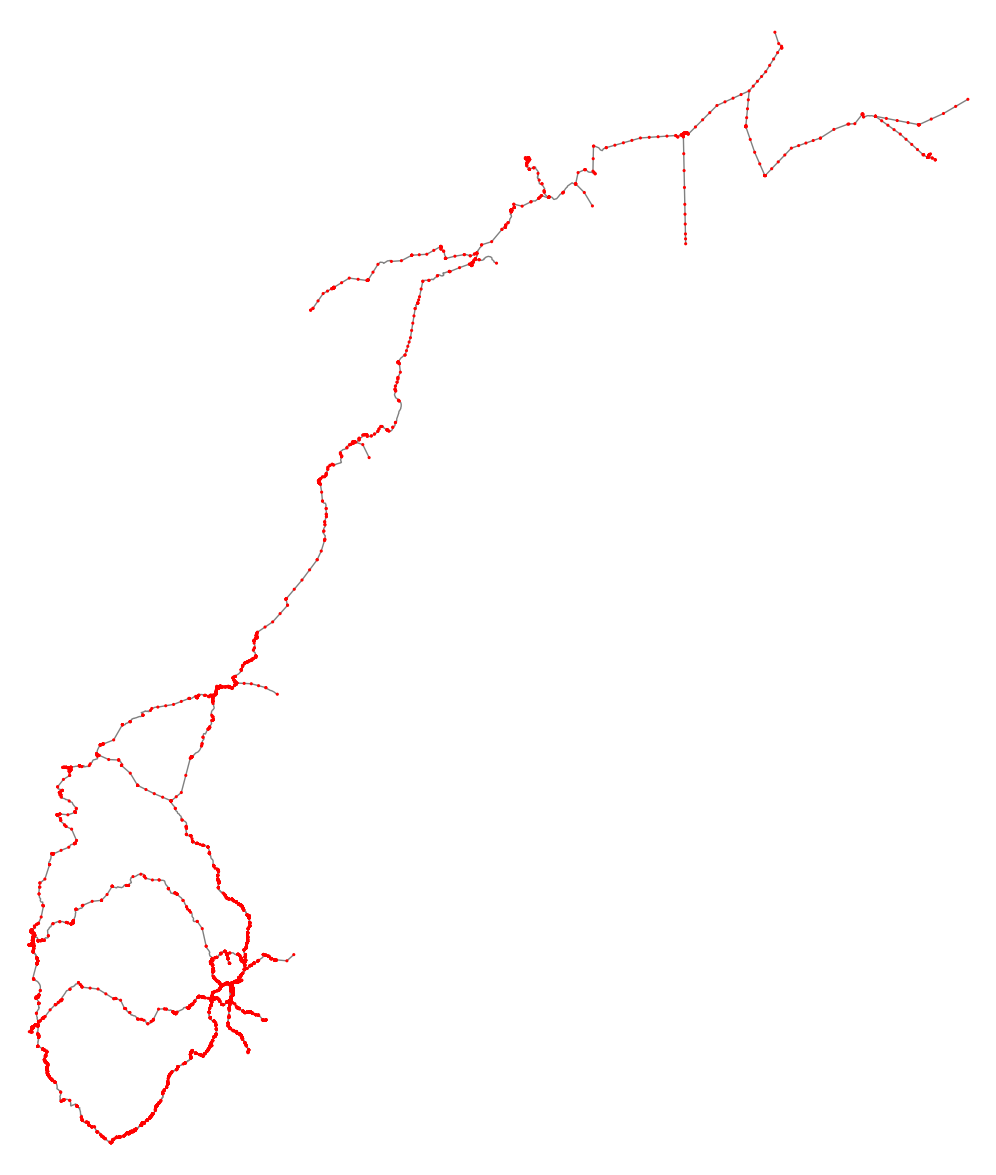

(<Figure size 3000x1500 with 1 Axes>, <AxesSubplot:>)

In [5]:
#Plot graph
# ox.plot_graph(H, figsize = (30, 15), node_color="red", edge_color = "gray", bgcolor = "white", node_size=1, edge_linewidth = 1)
ox.plot_graph(G, figsize = (30, 15), node_color="red", edge_color = "gray", bgcolor = "white", node_size=5, edge_linewidth = 1)

In [6]:
# Create an empty dataframe to store node attributes
node_df = pd.DataFrame(columns=['node', "osmid", "latitude", "longitude", 'gradient', "isBridge", "isTunnel", "roadclass", "geometry"])

# Iterate over all nodes in the network
# Note: Generates a lot of output - clear cell output after the code has run - must be a better way to this 
for node in G.nodes:
    # Get the gradient attribute of the node and add it to the dataframe
    osmid = G.nodes[node]["osmid"]
    lat = G.nodes[node]["x"]
    lon = G.nodes[node]["y"]
    isBridge = G.nodes[node]["isBridge"]
    isTunnel = G.nodes[node]["isTunnel"]
    roadclass = G.nodes[node]["roadclass"]
    gradient = G.nodes[node]['elevation']
    geo = G.nodes[node]["geometry"]

    node_df = node_df.append({"osmid": osmid, 'node': node, "latitude": lon, "longitude": lat, 'gradient': gradient, "isBridge": isBridge, "isTunnel": isTunnel, "roadclass": roadclass, "geometry": geo}, ignore_index=True)

C:\Users\anton\AppData\Local\Temp\ipykernel_1820\1116386944.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append({"osmid": osmid, 'node': node, "latitude": lon, "longitude": lat, 'gradient': gradient, "isBridge": isBridge, "isTunnel": isTunnel, "roadclass": roadclass, "geometry": geo}, ignore_index=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_1820\1116386944.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node_df = node_df.append({"osmid": osmid, 'node': node, "latitude": lon, "longitude": lat, 'gradient': gradient, "isBridge": isBridge, "isTunnel": isTunnel, "roadclass": roadclass, "geometry": geo}, ignore_index=True)
C:\Users\anton\AppData\Local\Temp\ipykernel_1820\1116386944.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

In [7]:
# Convert the edge data to a pandas DataFrame
edge_data = G.edges(data=True)
edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
edge_df = pd.concat([edge_df.drop('data_dict', axis=1), edge_df['data_dict'].apply(pd.Series)], axis=1)


In [8]:
# Print the resulting DataFrames
display(edge_df.head())
display(node_df.head())
print("Other than source and target, the actual only interesting attribute in edge_df is:   \033[1mlength, length_weight, grade, grade_abs, and geometry\033[0m")

source  target                                          id  oneway  \
0  155191  155273                                      138086   False   
1  155191  351348           [138014, 2168667, 362740, 363590]   False   
2  155191  155201    [138118, 138126, 138134, 138142, 138150]   False   
3  155201  155289                                      138110   False   
4  155201  351618  [363598, 362732, 2168670, 2168673, 138022]   False   

             ref           name  funcroadclass roadclass isFerry isBridge  \
0  Kjonerudvegen  Kjonerudvegen              0         0       0        0   
1             E6             E6              0         0       0        0   
2  Kjonerudvegen  Kjonerudvegen              0         0       0        0   
3  Kjonerudvegen  Kjonerudvegen              0         0       0        0   
4             E6             E6              0         0       0        0   

  isTunnel speedlim                                          drivetime  \
0        0       60                                           0.017585   
1        0      110  [0.003121153025136814, 0.19838599168327925, 0....   
2        0       60  [0.020742835002232715, 0.007996503314164363, 0...   
3        0       60                                           0.013559   
4        0      110  [0.025416070719352715, 0.04081408948645507, 0....   

       length                                      length_weight  \
0   15.291208                                          15.291208   
1  485.743882  [4.975751199493471, 316.2675229733437, 129.096...   
2   54.859300  [18.037247828028452, 6.953481142751621, 4.6441...   
3   11.790339                                          11.790339   
4  377.468769  [40.51837361056231, 65.06593976101533, 259.661...   

                                           u  \
0                                     155191   
1           [155191, 155192, 351173, 351174]   
2    [155201, 24154, 155317, 155327, 155337]   
3                                     155289   
4  [351618, 351165, 351166, 1854868, 155200]   

                                           v  \
0                                     155273   
1           [155192, 351173, 351174, 351348]   
2    [24154, 155317, 155327, 155337, 155191]   
3                                     155201   
4  [351165, 351166, 1854868, 155200, 155201]   

                                  grade                            grade_abs  \
0                                 -0.03                                 0.03   
1         [-0.002, 0.013, 0.034, 0.018]         [0.002, 0.013, 0.034, 0.018]   
2  [0.031, 0.027, 0.018, 0.005, -0.018]  [0.031, 0.027, 0.018, 0.005, 0.018]   
3                                 0.013                                0.013   
4   [0.056, 0.053, 0.042, 0.028, 0.025]  [0.056, 0.053, 0.042, 0.028, 0.025]   

   wa_grade                                           geometry  
0 -0.030000                                                NaN  
1  0.018792  LINESTRING (11.127465806112035 60.786204560258...  
2  0.008434  LINESTRING (11.127184981853482 60.786428543984...  
3  0.013000                                                NaN  
4  0.044906  LINESTRING (11.125266280578165 60.789677274131...

node   osmid   latitude  longitude  gradient isBridge isTunnel roadclass  \
0  155191  155191  60.786205  11.127466   143.160        0        0         0   
1  155201  155201  60.786429  11.127185   142.700        0        0         0   
2  155273  155273  60.786334  11.127535   142.705        0        0         0   
3  155289  155289  60.786416  11.127400   142.543        0        0         0   
4  155971  155971  60.189189  11.993829   155.408        0        0         0   

                                        geometry  
0   POINT (11.127465806112035 60.78620456025842)  
1   POINT (11.127184981853482 60.78642854398455)  
2   POINT (11.127534712389643 60.78633428345484)  
3  POINT (11.127399824588059 60.786415782679235)  
4  POINT (11.993829462815306 60.189188517538796)

Other than source and target, the actual only interesting attribute in edge_df is:   length, length_weight, grade, grade_abs, and geometry


In [9]:
# Check number of NaN in geometry column
nodes_nans = node_df["geometry"].isna().sum()
print(f"IN NODES:   The column geometry contains {nodes_nans} of", len(node_df), "NaN values.")

edges_nans = edge_df["geometry"].isna().sum()
print(f"IN EDGES:   The column geometry contains {edges_nans} of", len(edge_df), "NaN values.")


IN NODES:   The column geometry contains 0 of 6944 NaN values.
IN EDGES:   The column geometry contains 1629 of 9807 NaN values.


In [10]:
# Drop all edges without a geometry column
edge_df.dropna(subset=["geometry"], inplace=True)
edges_nans = edge_df["geometry"].isna().sum()
print(f"IN EDGES:   The column geometry contains {edges_nans} of", len(edge_df), "NaN values.")
#edge_df.head()


IN EDGES:   The column geometry contains 0 of 8178 NaN values.


In [11]:
# Convert the dataframes to geodataframes, using the "geometry" column as the geometry
edge_gdf = gpd.GeoDataFrame(edge_df, geometry="geometry")
node_gdf = gpd.GeoDataFrame(node_df, geometry="geometry")

In [13]:
# Very much data - to much
display(node_gdf.info())
display(edge_gdf.info())
print("Too much data")

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6944 entries, 0 to 6943
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   node       6944 non-null   object  
 1   osmid      6944 non-null   object  
 2   latitude   6944 non-null   float64 
 3   longitude  6944 non-null   float64 
 4   gradient   6944 non-null   float64 
 5   isBridge   6944 non-null   object  
 6   isTunnel   6944 non-null   object  
 7   roadclass  6944 non-null   object  
 8   geometry   6944 non-null   geometry
dtypes: float64(3), geometry(1), object(5)
memory usage: 488.4+ KB


None

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8178 entries, 1 to 9806
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   source         8178 non-null   int64   
 1   target         8178 non-null   int64   
 2   id             7993 non-null   object  
 3   oneway         8178 non-null   bool    
 4   ref            8178 non-null   object  
 5   name           8178 non-null   object  
 6   funcroadclass  8178 non-null   int64   
 7   roadclass      8178 non-null   object  
 8   isFerry        8178 non-null   object  
 9   isBridge       8178 non-null   object  
 10  isTunnel       8178 non-null   object  
 11  speedlim       8178 non-null   object  
 12  drivetime      7993 non-null   object  
 13  length         8178 non-null   float64 
 14  length_weight  7993 non-null   object  
 15  u              7993 non-null   object  
 16  v              7993 non-null   object  
 17  grade          8178 non-n

None

Too much data


To many nodes on the same locations...


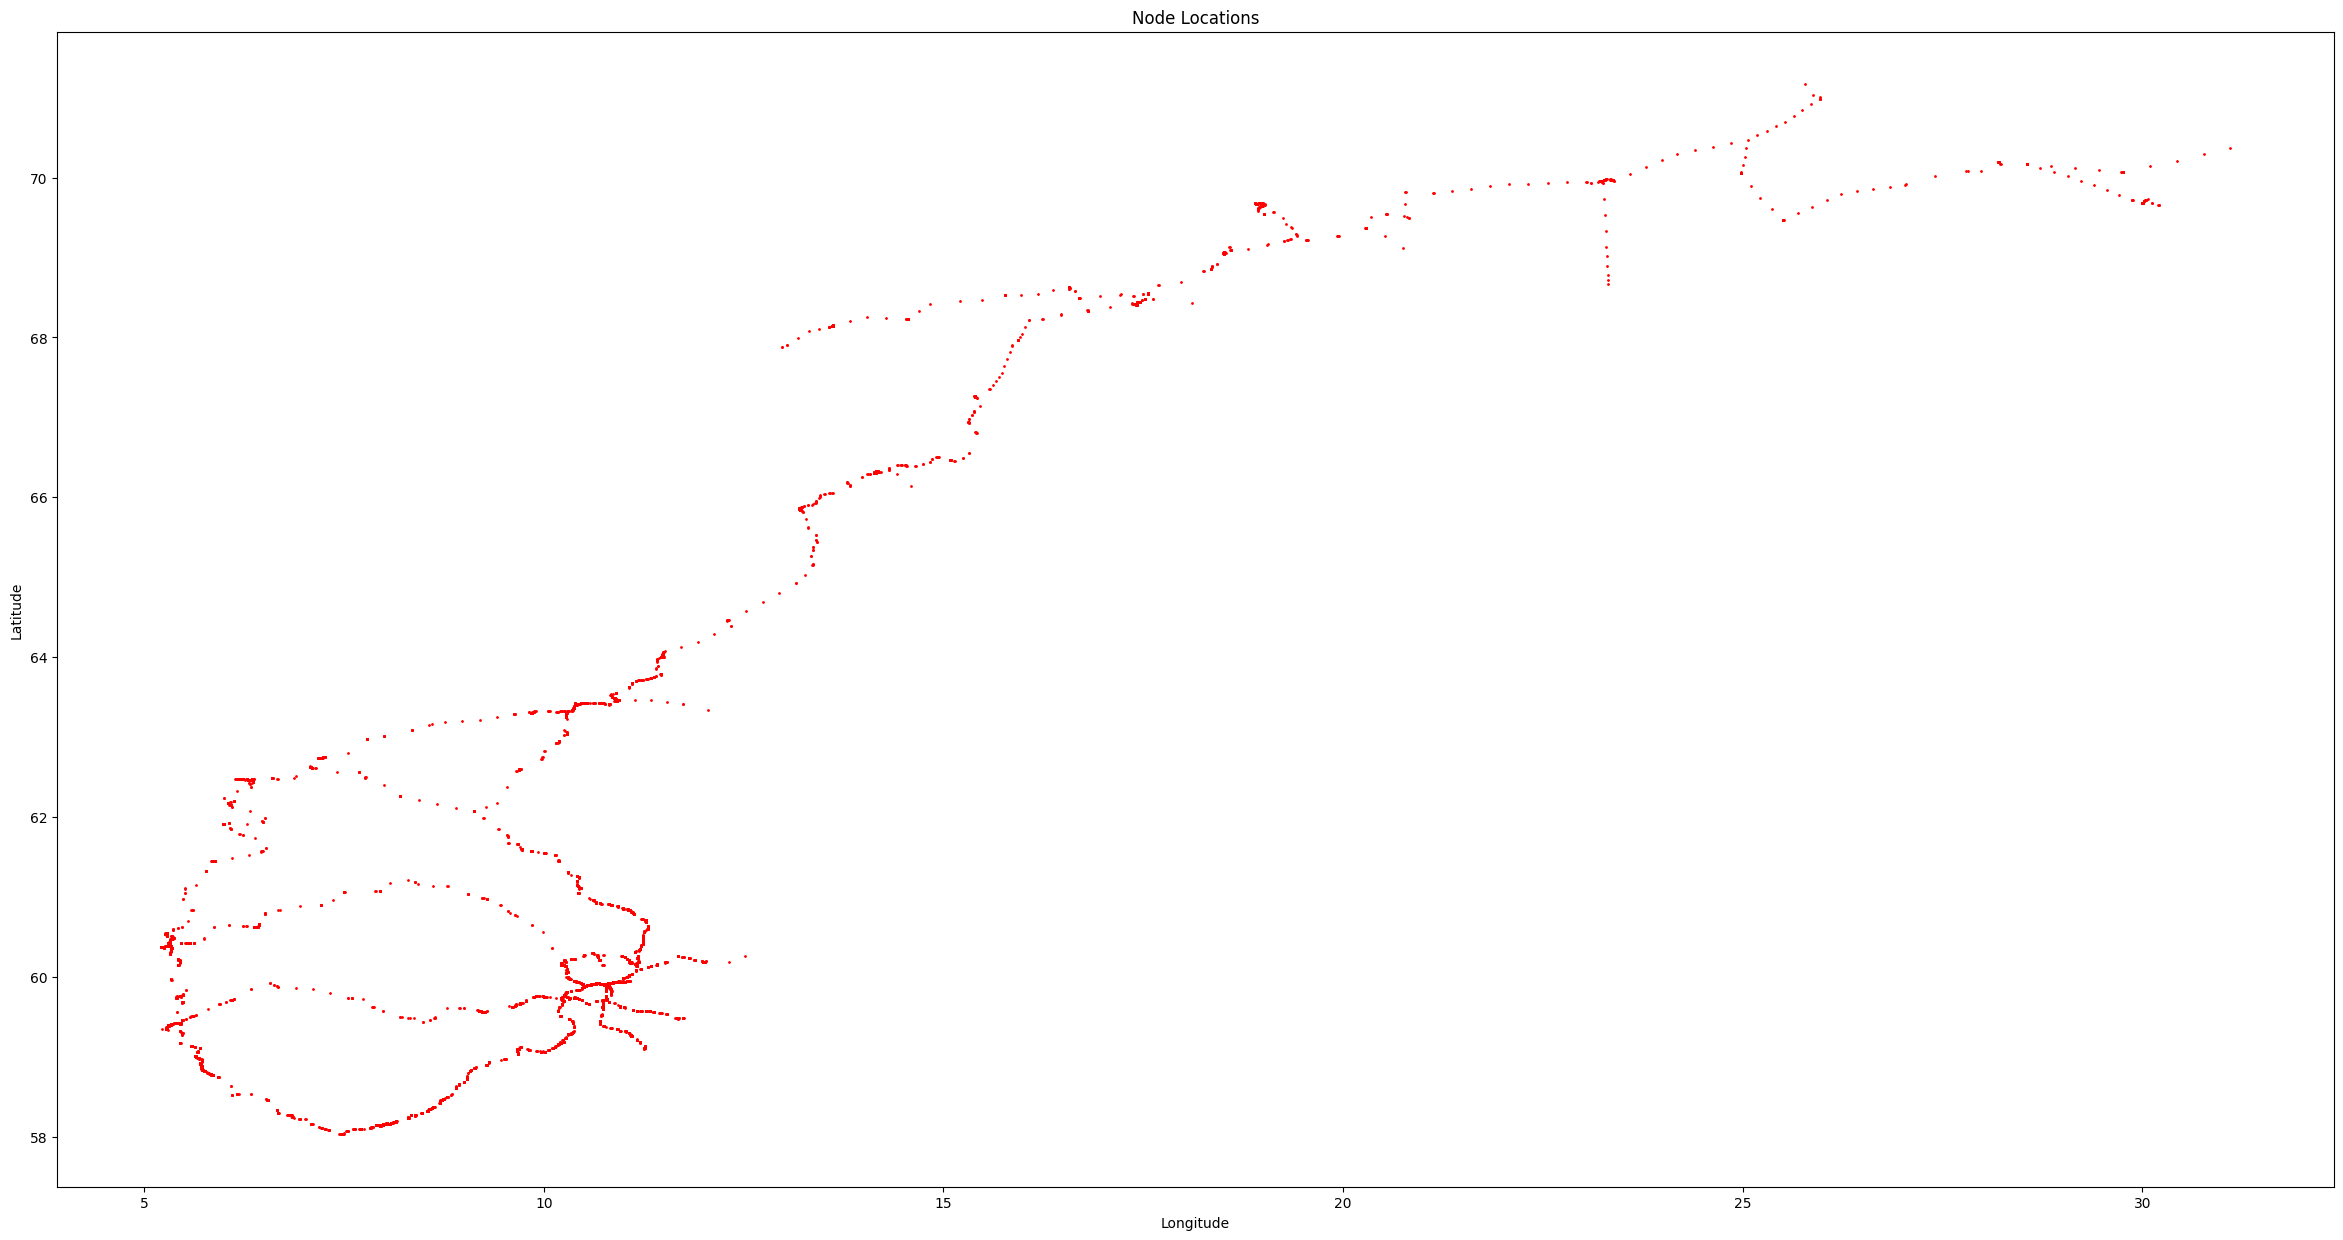

In [14]:
import matplotlib.pyplot as plt

# Create a scatter plot of the node locations
fig, ax = plt.subplots(figsize=(30, 15))
node_gdf.plot(ax=ax, markersize=1, color = 'red')

# Add a title and axis labels
ax.set_title("Node Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("To many nodes on the same locations...")
# Display the plot
plt.show()


Same plot but with the edges as well


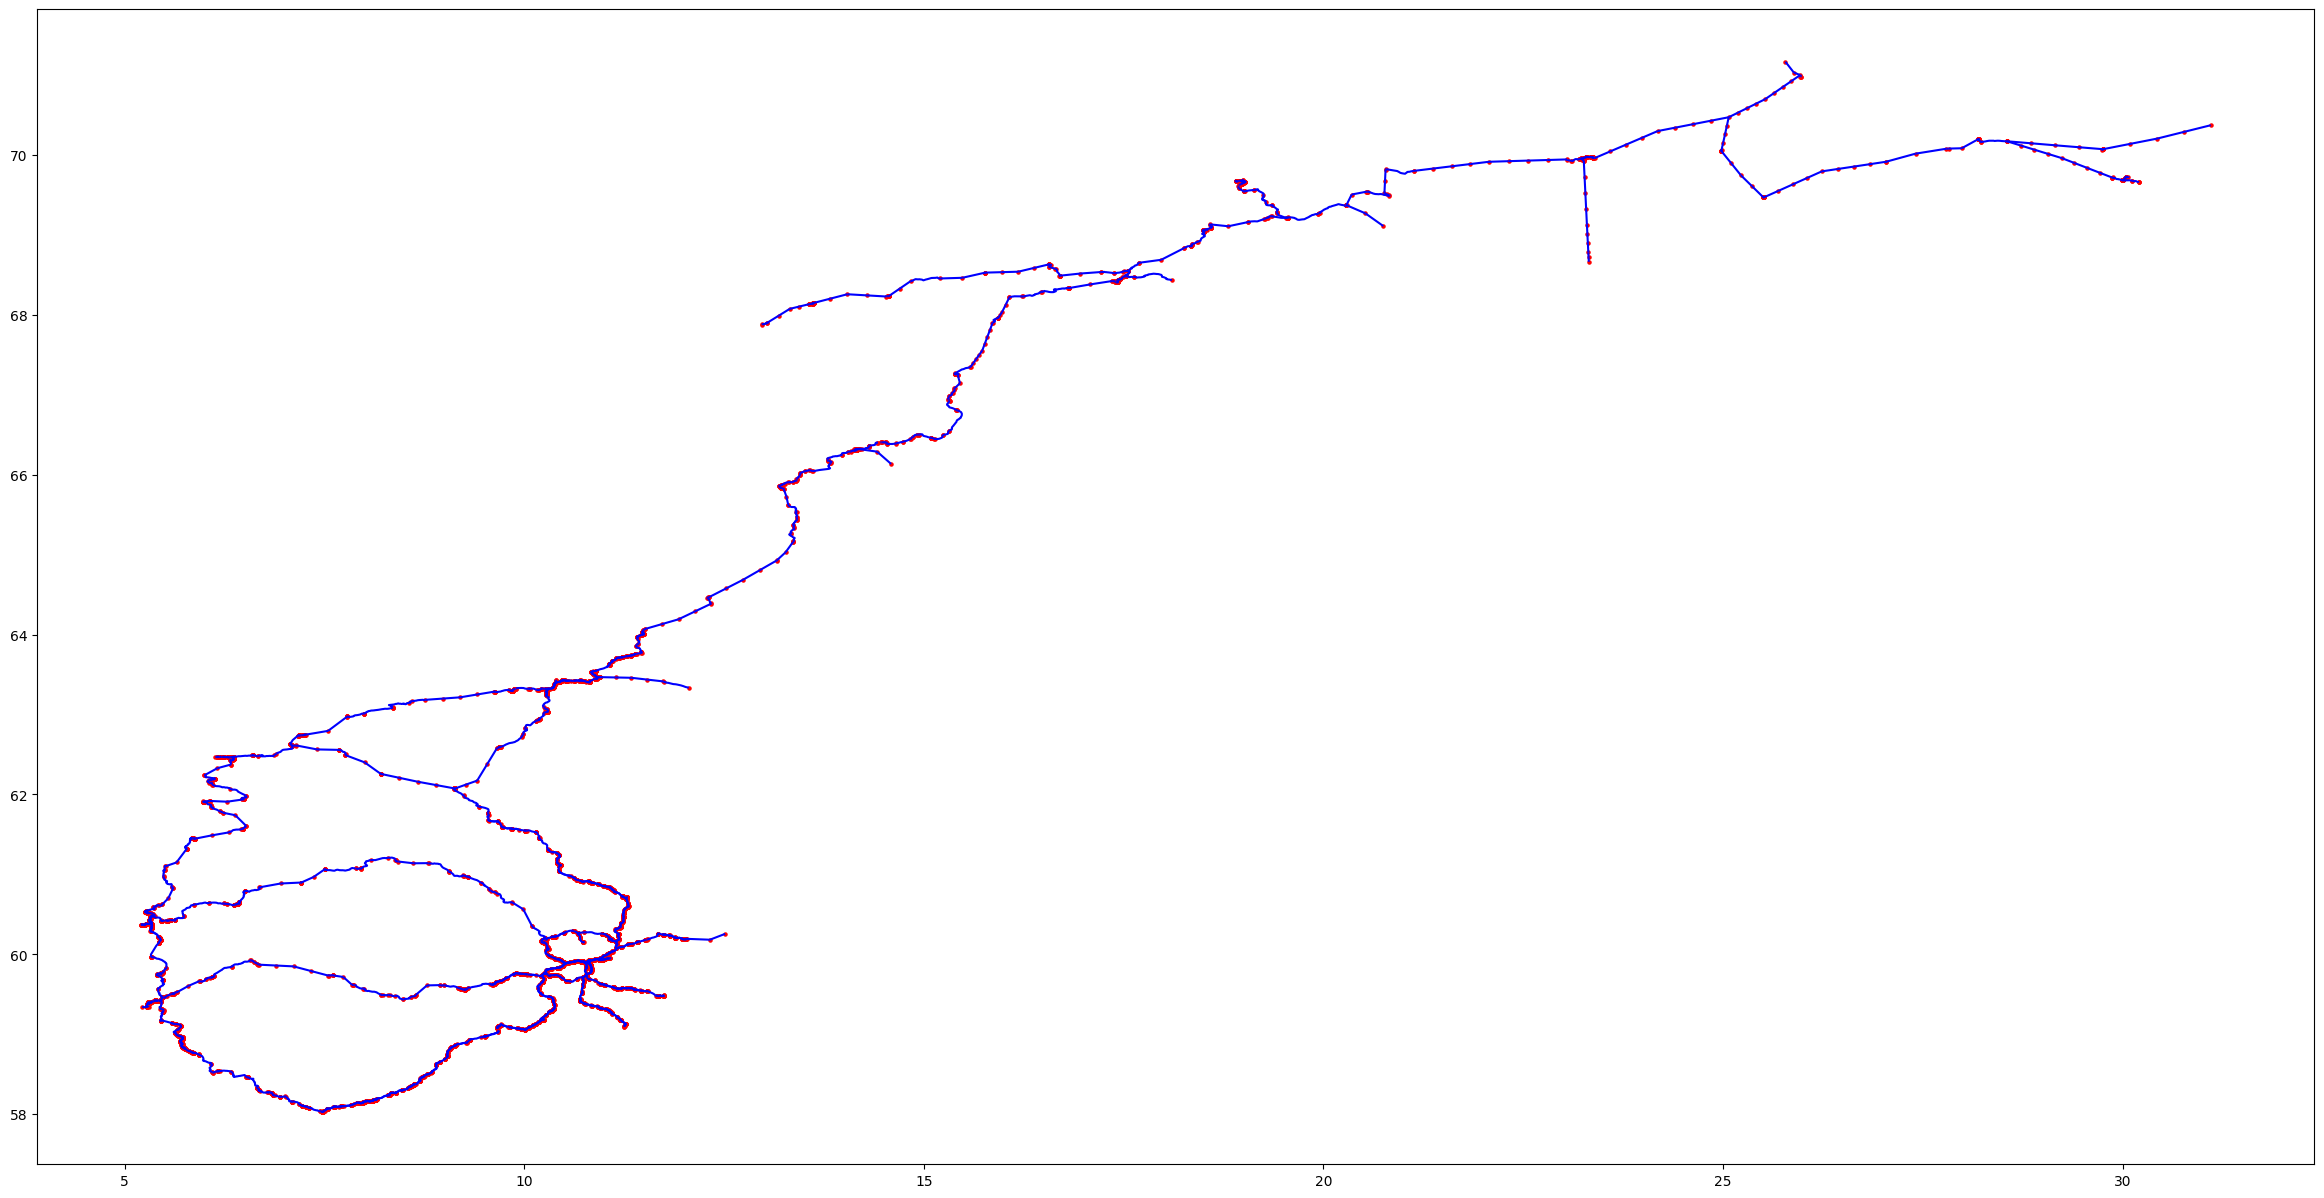

In [16]:
# Same plot but with the edges as well
# Set the size of the plot
fig, ax = plt.subplots(figsize=(30, 15))

# Plot the nodes and edges
edge_gdf.plot(ax=ax, color='blue')
node_gdf.plot(ax=ax, color='red', markersize=5)


# Show the plot
print("Same plot but with the edges as well")
plt.show()


<h3>We will from the network above make a more simplified network<h3>

In [17]:
# The ID´s of the nodes we want to keep:
node_ids = [
363114, 155191, 351102, 229327, 1287001, 294257, 1210066, 1550099, 1549832, 1548053, 1166768, 1391983, 1355042, 1540900, 1354548, 1596708, 1831177, 346860, 1361083, 1820460, 273005, 264633, 212063, 264384, 733439,
249770, 1621813, 1620935, 1287788, 226166, 1035188, 225533, 1804949, 1358093, 825322, 1401860, 1360772, 1653413, 744348, 655059, 1692454, 322944, 717788, 1259667, 733331, 717094, 1367541, 1368219, 1359263, 1357128, 
1359748, 1534536, 1363061, 729893, 1068477, 645755, 521003, 734848, 518987, 1356899, 1388481, 1059419, 646017, 646755, 1498010, 1499783, 1583718, 1583052, 1502720, 1241680,1356545, 1361908, 475528, 1357826, 473308, 1502547, 1520568, 1502400, 
1502160, 1047298, 1059253, 1059028, 1457640, 1520306, 1359965, 1297915, 1117282, 344396, 918793, 1160470, 1461371, 419975, 1353166, 1391824, 1353882, 1457875, 1300885, 591920, 1148914, 1148963, 932927, 875935, 892203, 
815860, 816117, 932076, 938601, 939342, 1525237, 925287, 819302, 819545, 947862, 837851, 834022, 518394, 1277008, 904906, 1305301, 959684, 884154, 861726, 778683, 439557, 931408, 935675, 1164626, 1165904, 
917667, 633563, 1835024, 1064864, 1063773, 1058365, 1107032, 363094, 1169582, 1168841, 1114554, 442791, 939314, 1837088, 1112692, 1119099, 443012, 1253262, 786013, 359628, 356907, 1244249, 
360832, 974682, 1308424, 1294532, 783491, 352537, 677129, 785659, 1211419, 1202331, 780210, 373466, 1767627, 1251008, 1306941, 278721, 1306939, 1220377, 1236482, 518781, 519032, 519215, 1854804, 519657, 
519871, 356470, 1218458, 520142, 950607, 1854811, 520266, 1854850, 1854805, 1854873, 1757217, 1757294, 1178154, 456094, 960370, 1854799, 1212916, 1742443, 356803, 1790694, 1714915, 347578, 354561, 1091549,
1753909, 1753950, 1292044, 824526, 1761273, 1311226, 786184, 1854829, 263259, 343979, 120302, 239563, 240306, 338653, 341391, 941568, 1655795, 981136, 1695865, 1797345, 329937, 1703037, 1761012, 
1751958, 1752000, 1847362, 1255189, 1753123, 1244158, 1810129, 1244173, 1447438, 1752379, 1757410, 1751303, 1762198, 1798422, 1774526, 1754488, 1757182, 1757211, 1847506, 1752913, 1291319, 1622377, 1757013, 1757052, 
1757063, 1854845, 687472, 1661302, 1342897, 460424, 1854801, 1811243, 1662585, 1455254, 1854841, 982313, 1263183, 1242665, 1663567, 1854835, 1656101, 951446, 664979, 1656119, 1667799, 1854844, 
1670339, 1659666, 1819808, 730907, 320750, 943010, 943332, 1205589, 1854836, 323551, 645165, 1220506, 945389, 1234021, 1218653, 1209902, 1207592, 1218415, 1211360, 943633, 1552659, 1220312, 943904, 943905, 1853430, 
1853486, 1233937, 1854796, 332952, 945719, 343936, 944789, 345153, 345690, 1854797, 936216, 1173462, 345756, 960480, 587711, 1854889,  356032, 355924, 362649, 358102, 326002, 332126, 331992, 232649, 
232847, 232965, 293304, 293574, 293678, 233289, 233695, 328981, 328559, 1053393, 328043, 328308, 235735, 1161983, 236596, 236965, 1854846, 1854793, 1854869, 957034, 1854810, 1262340, 1854867, 1854838, 1854890, 444183, 1114288, 660263, 
601243, 579725, 556936, 1204452, 981995, 664358, 621046, 1050156, 656715, 673595, 673499, 1050042, 622986, 601834, 621503, 621605, 1591175, 601899, 601845, 623104, 579107, 452992, 579231, 255966, 1244855,
982265, 1854859, 1854820, 1854882, 602188, 902303, 627813, 628008, 628147, 541335, 203067, 203338, 628790, 622372, 532078, 628971, 541694, 541794, 567100, 630261, 497797, 592884, 1854837, 1854866, 1240203, 612442, 597346, 582037, 581827, 
581633, 581536, 600113, 621923, 184851, 1854807, 1854874, 621978, 622201, 1854852, 1854808, 1854875, 634052, 1854809, 826281, 674327, 375163, 1764735, 429135, 619605, 1854806, 932344, 659061, 658639, 658705, 658738, 658913, 658947, 
658978, 474029, 474067, 474526, 47559, 474788, 475173, 475424, 1494993, 984851, 395203, 600782, 984889, 984897, 1854822, 975964, 490719, 368717, 690247, 672996, 1570377, 353427, 1571858, 374652, 599379, 355303, 354996, 355108, 355216, 785532, 
467677, 348200, 925506, 957739, 476859, 476941, 477134, 1854802, 1303455, 429248, 1095056, 1854898, 1854865, 1854912, 1854833, 1854905, 1854888, 1854919, 425412, 1274054, 1854868, 1854839, 1854891, 426202, 480059, 
480347, 1572082, 1854842, 290493, 253044, 990173, 1170474, 1225629, 430614, 331452, 431864, 432008, 439279, 1854800, 439585, 1012611, 1012732, 1012835, 1854861, 1854828, 1854884, 1278515, 1854840, 
975434, 982469, 1854821, 941253, 1854849, 1854803, 1854872, 283367, 293924, 1854847, 1854794, 1854870, 448431, 1781068, 331534, 917559, 1854827, 1040580, 918139, 1806461, 739490, 1616680, 1005467, 1005585, 1016544, 1854826, 1016548, 
1006350, 1006563, 1016827, 644771, 1011677, 1011753, 1017172, 1011881, 1011888, 1045653, 281536, 461376, 935246, 1012112, 1012181, 1226405, 1017224, 1027717, 1015021,1016957, 1017026, 323285, 1854825, 1010761, 1854795, 665731, 368090, 1854798, 
1854871, 1808899, 1009585, 1854896, 1854860, 1854910, 1854824, 1854883, 1824695, 978654, 1048365, 1854897, 1854862, 1854911, 1854830, 1854904, 1854885, 1854918, 1854920, 973741, 979032, 424527, 972167, 1854892, 1854853, 1854906, 1854812, 
1854899, 1854876, 1854913, 973790, 1854893, 1854855, 1854907, 1854814, 1854900, 1854878, 1854914, 1098392, 1854834, 989213, 1854854, 1854813, 979185, 1854857, 1854817, 1084015, 1854858, 1854909, 1854902, 1854916, 1100062, 1854815, 1854823, 967923, 1096451, 
1854863, 1854831, 1854886, 969943, 1854894, 1854856, 1854908, 1854816, 1854901, 1854879, 1854915, 1096879, 1096416 
]

In [18]:
# Create a boolean mask indicating which rows have the desired IDs
mask = node_gdf['osmid'].isin(node_ids)

# create a new geodataframe with only the desired rows
new_gdf_ids = node_gdf[mask].copy()

# reset the index of the new geodataframe
new_gdf_ids.reset_index(drop=True, inplace=True)

new_gdf_ids.info()
print("Around 600 entries.")


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   node       619 non-null    object  
 1   osmid      619 non-null    object  
 2   latitude   619 non-null    float64 
 3   longitude  619 non-null    float64 
 4   gradient   619 non-null    float64 
 5   isBridge   619 non-null    object  
 6   isTunnel   619 non-null    object  
 7   roadclass  619 non-null    object  
 8   geometry   619 non-null    geometry
dtypes: float64(3), geometry(1), object(5)
memory usage: 43.6+ KB
Around 600 entries.


In [19]:
# Manually make the edges between the nodes - may use a code for doing this - "finding nearest neighbour" or something (?)
edges_list =[
   (363114, 155191),
(155191, 351102),
(351102, 229327),
(229327, 1287001),
(1287001, 294257),
(294257, 1210066),
(1210066, 1550099),
(1550099, 1549832),
(1549832, 1548053),
(1548053, 1166768),
(1166768, 1391983),
(1391983, 1355042),
(1355042, 1540900),
(1540900, 1354548),
(1354548, 1596708),
(1596708, 1831177),
(1831177, 346860),
(1166768, 1361083),
(1361083, 1820460),
(1820460, 273005),
(273005, 264633),
(264633, 212063),
(212063, 264384),
(264384, 733439),
(264633, 249770),
(249770, 1621813),
(1621813, 1620935),
(1287788, 226166),
(1620935, 226166),
(226166, 1035188),
(1287788, 225533),
(225533, 1804949),
(1804949, 1358093),
(1358093, 825322),
(825322, 1401860),
(1401860, 1360772),
(1360772, 744348),
(1653413, 744348),
(744348, 655059),
(655059, 1692454),
(1692454, 322944),
(322944, 717788),
(1692454, 1259667),
(1259667, 733331),
(733331, 717094),
(717094, 1367541),
(1367541, 1368219),
(1368219, 1359263),
(1359263, 1357128),
(1367541, 733439),
(1357128, 1359748),
(1359748, 1534536),
(1534536, 1363061),
(1363061, 1391983),
(717788, 729893),
(729893, 1068477),
(733331, 521003),
(521003, 734848),
(734848, 518987),
(518987, 1356899),
(1356899, 1068477),
(1068477, 1388481),
(1388481, 1059419),
(1059419, 646017),
(646017, 1498010),
(1498010, 1499783),
(1499783, 1583718),
(1583718, 1583052),
(1583052, 1502720),
(1502720, 1241680),
(1388481, 1356545),
(1356545, 1361908),
(1361908, 475528),
(475528, 1357826),
(1357826, 473308),
(473308, 1502547),
(1502547, 1520568),
(1520568, 1502400),
(1502400, 1502160),
(1502160, 1047298),
(1047298, 1059253),
(1059253, 1059028),
(1059028, 1457640),
(1457640, 1520306),
(1356545, 1359965),
(1359965, 1297915),
(1297915, 1117282),
(1117282, 344396),
(344396, 918793),
(918793, 1160470),
(1160470, 1461371),
(1461371, 419975),
(419975, 1353166),
(1353166, 1391824),
(1391824, 1353882),
(1353882, 1401860),
(1461371, 1457875),
(1457875, 1300885),
(1457875, 591920),
(591920, 1148914),
(1148914, 1148963),
(1148963, 932927),
(932927, 875935),
(875935, 892203),
(892203, 815860),
(815860, 816117),
(816117, 932076),
(932076, 938601),
(938601, 939342),
(939342, 1525237),
(1525237, 925287),
(925287, 819302),
(819302, 819545),
(819545, 947862),
(947862, 837851),
(837851, 834022),
(834022, 518394),
(518394, 1277008),
(1277008, 904906),
(904906, 1305301),
(1305301, 959684),
(959684, 884154),
(884154, 861726),
(861726, 778683),
(778683, 439557),
(439557, 931408),
(931408, 1164626),
(931408, 935675),
(935675, 1164626),
(1164626, 1165904),
(1165904, 917667),
(917667, 633563),
(633563, 1835024),
(1835024, 1064864),
(1064864, 1063773),
(1063773, 1058365),
(1058365, 1107032),
(1107032, 363094),
(363094, 1169582),
(1169582, 1168841),
(1168841, 1114554),
(1114554, 442791),
(442791, 939314),
(939314, 1837088),
(1837088, 1112692),
(1112692, 1119099),
(1119099, 443012),
(443012, 1253262),
(1253262, 786013),
(786013, 359628),
(359628, 356907),
(356907, 1244249),
(1244249, 360832),
(360832, 974682),
(974682, 1308424),
(1308424, 1294532),
(1294532, 783491),
(783491, 352537),
(352537, 677129),
(677129, 785659),
(785659, 1211419),
(1211419, 1202331),
(1202331, 780210),
(373466, 1767627),
(1767627, 1251008),
(1251008, 1306941),
(278721, 1306939),
(1306939, 1220377),
(1220377, 1236482),
(1236482, 518781),
(518781, 519032),
(519032, 519215),
(519215, 1854804),
(1854804, 519657),
(519657, 519871),
(519871, 356470),
(356470, 1218458),
(1218458, 520142),
(520142, 950607),
(950607, 1854811),
(1854811, 520266),
(520266, 1854850),
(1854850, 1854805),
(1854805, 1854873),
(1854873, 1757217),
(1757217, 1757294),
(1757294, 1178154),
(1178154, 456094),
(456094, 960370),
(960370, 1854799),
(1854799, 1212916),
(1212916, 1742443),
(1742443, 356803),
(356803, 1790694),
(356803, 1714915),
(1714915, 347578),
(347578, 354561),
(354561, 373466),
(373525, 1091549),
(1790694, 1753909),
(1753909, 1753950),
(1753950, 1292044),
(1292044, 824526),
(1292044, 1761273),
(1761273, 1311226),
(1311226, 786184),
(780210, 347578),
(1035188, 1854829),
(1854829, 263259),
(263259, 343979),
(343979, 120302),
(120302, 239563),
(239563, 240306),
(240306, 338653),
(338653, 341391),
(341391, 941568),
(941568, 1655795),
(1655795, 981136),
(981136, 1695865),
(1695865, 1797345),
(1797345, 329937),
(329937, 1703037),
(1703037, 1761012),
(1761012, 1751958),
(1751958, 1752000),
(1752000, 1847362),
(786184, 1255189),
(1255189, 1753123),
(1753123, 1244158),
(1244158, 1810129),
(1810129, 1244173),
(1244173, 1447438),
(1447438, 1752379),
(1752379, 1757410),
(1757410, 1751303),
(1751303, 1762198),
(1762198, 1798422),
(1798422, 1774526),
(1751303, 1754488),
(1754488, 1757182),
(1757182, 1757211),
(1757211, 1847362),
(1847362, 1847506),
(1847506, 1752913),
(1752913, 1291319),
(1291319, 1622377),
(1622377, 1757013),
(1757013, 1757052),
(1757052, 1757063),
(1757063, 1854845),
(1854845, 687472),
(687472, 1661302),
(1661302, 1342897),
(1342897, 460424),
(460424, 1854801),
(1854801, 1811243),
(1811243, 1662585),
(1662585, 1455254),
(1455254, 1854841),
(1854841, 982313),
(982313, 1263183),
(1263183, 1242665),
(1242665, 1663567),
(1663567, 1854835),
(1854835, 1656101),
(1656101, 951446),
(951446, 664979),
(664979, 1656119),
(1656119, 1667799),
(1667799, 1854844),
(1854844, 1670339),
(1670339, 1659666),
(1659666, 1819808),
(1819808, 730907),
(730907, 320750),
(320750, 943010),
(943010, 943332),
(943332, 1205589),
(1205589, 1854836),
(1854836, 323551),
(323551, 645165),
(645165, 1220506),
(1220506, 945389),
(945389, 1234021),
(1234021, 1218653),
(1218653, 1209902),
(1209902, 1207592),
(1207592, 1218415),
(1218415, 1211360),
(1234021, 943633),
(943633, 1552659),
(1552659, 1220312),
(1220312, 943904),
(943904, 943905),
(943905, 1853430),
(1853430, 1853486),
(1853486, 1233937),
(1233937, 1854796),
(1854796, 332952),
(1853430, 945719),
(945719, 343936),
(343936, 944789),
(944789, 345153),
(345153, 345690),
(345690, 1854797),
(1854797, 936216),
(936216, 1173462),
(1173462, 345756),
(345756, 960480),
(960480, 587711),
(587711, 1854889),
(363114, 356032),
(356032, 355924),
(355924, 362649),
(362649, 358102),
(358102, 326002),
(326002, 332126),
(332126, 331992),
(331992, 232649),
(232649, 232847),
(232847, 232965),
(232965, 293304),
(293304, 293574),
(293574, 293678),
(293678, 233289),
(233289, 233695),
(233695, 328981),
(328981, 328559),
(328559, 1053393),
(1053393, 328043),
(328043, 328308),
(328308, 235735),
(235735, 1161983),
(1161983, 236596),
(236596, 236965),
(236965, 1854846),
(1854846, 1854793),
(1854793, 1854869),
(1854869, 957034),
(957034, 1854810),
(1854810, 1262340),
(1262340, 332952),
(236965, 1854867),
(1854867, 1854838),
(1854838, 1854890),
(1854890, 444183),
(444183, 1114288),
(1114288, 660263),
(660263, 601243),
(601243, 579725),
(579725, 556936),
(556936, 1204452),
(1204452, 981995),
(981995, 664358),
(664358, 621046),
(621046, 1050156),
(1050156, 656715),
(656715, 673595),
(673595, 673499),
(673499, 1050042),
(1050042, 622986),
(622986, 601834),
(601834, 621503),
(621503, 621605),
(621605, 623104),
(1591175, 601899),
(601899, 601845),
(601845, 601834),
(623104, 579107),
(579107, 452992),
(452992, 579231),
(579231, 255966),
(255966, 1244855),
(1244855, 982265),
(982265, 1854859),
(1854859, 1854820),
(1854820, 1854882),
(1854882, 602188),
(602188, 902303),
(1244855, 627813),
(627813, 628008),
(628147, 541335),
(541335, 203067),
(203067, 203338),
(203338, 628790),
(628790, 622372),
(622372, 532078),
(532078, 628971),
(628971, 541694),
(541694, 541794),
(541794, 567100),
(567100, 630261),
(630261, 497797),
(497797, 592884),
(1854889, 1854837),
(1854837, 1854866),
(1854866, 1240203),
(1240203, 612442),
(612442, 597346),
(597346, 582037),
(582037, 581827),
(581827, 581633),
(581633, 581536),
(581536, 656715),
(592884, 600113),
(600113, 621923),
(621923, 1854807),
(1854807, 1854874),
(1854874, 621978),
(621978, 622201),
(622201, 1854852),
(1854852, 1854808),
(1854808, 1854875),
(1854875, 634052),
(634052, 1854809),
(1854809, 826281),
(826281, 674327),
(674327, 375163),
(375163, 1764735),
(1764735, 429135),
(429135, 619605),
(619605, 1854806),
(1854806, 932344),
(932344, 659061),
(659061, 658705),
(658705, 658738),
(658738, 658913),
(658913, 658947),
(658947, 658978),
(658978, 474029),
(474029, 474067),
(474067, 474526),
(474526, 474788),
(474788, 475173),
(475173, 475424),
(475424, 1494993),
(1494993, 984851),
(984851, 395203),
(395203, 600782),
(984851, 984889),
(984889, 984897),
(984897, 1854822),
(1854822, 975964),
(984851, 490719),
(490719, 368717),
(368717, 690247),
(690247, 1570377),
(1570377, 353427),
(353427, 1571858),
(1571858, 374652),
(374652, 599379),
(599379, 355303),
(355303, 354996),
(354996, 355108),
(355108, 355216),
(355216, 785532),
(785532, 467677),
(467677, 348200),
(348200, 925506),
(925506, 957739),
(957739, 476859),
(476859, 476941),
(476941, 477134),
(477134, 1854802),
(1854802, 1303455),
(1303455, 429248),
(429248, 1095056),
(1095056, 1854898),
(1854898, 1854865),
(1854865, 1854912),
(1854912, 1854833),
(1854833, 1854905),
(1854905, 1854888),
(1854888, 1854919),
(1854919, 425412),
(425412, 1274054),
(1274054, 1854868),
(1854868, 1854839),
(1854839, 1854891),
(1854891, 426202),
(426202, 480059),
(480059, 480347),
(480347, 1572082),
(1572082, 1854842),
(1854842, 290493),
(290493, 253044),
(253044, 990173),
(990173, 1170474),
(1170474, 1225629),
(1225629, 430614),
(1170474, 331452),
(331452, 431864),
(431864, 432008),
(432008, 439279),
(439279, 1854800),
(1854800, 439585),
(439585, 1012611),
(1012611, 1012732),
(1012732, 1012835),
(1012835, 1854861),
(1854861, 1854828),
(1854828, 1854884),
(1854884, 1278515),
(1278515, 1854840),
(1854840, 975434),
(975434, 982469),
(982469, 1854821),
(1854821, 941253),
(941253, 1854849),
(1854849, 1854803),
(1854803, 1854872),
(1854872, 283367),
(283367, 293924),
(293924, 1854847),
(1854847, 1854794),
(1854794, 1854870),
(1854870, 448431),
(448431, 1781068),
(331452, 331534),
(331534, 917559),
(917559, 1854827),
(1854827, 1040580),
(1040580, 918139),
(918139, 1806461),
(1806461, 739490),
(739490, 1616680),
(1616680, 1005467),
(1005467, 1005585),
(1005585, 1016544),
(1016544, 1854826),
(1854826, 1016548),
(1016548, 1006350),
(1006350, 1006563),
(1006563, 1016827),
(1016827, 644771),
(644771, 1011677),
(1011677, 1011753),
(1011753, 1017172),
(1017172, 1011881),
(1011881, 1011888),
(1011888, 1045653),
(1045653, 281536),
(281536, 461376),
(461376, 935246),
(935246, 1012112),
(1012112, 1012181),
(1012181, 1226405),
(1226405, 1017224),
(1017224, 1027717),
(1027717, 1015021),
(644771, 1016957),
(1016957, 1017026),
(1017026, 323285),
(323285, 1854825),
(1854825, 1010761),
(323285, 1854795),
(1854795, 665731),
(665731, 368090),
(368090, 1854798),
(1854798, 1854871),
(1854871, 1808899),
(1808899, 1009585),
(1009585, 1854896),
(1854896, 1854860),
(1854860, 1854910),
(1854910, 1854824),
(1854824, 1854883),
(1854883, 1824695),
(1824695, 978654),
(978654, 1048365),
(1048365, 1854897),
(1854897, 1854862),
(1854862, 1854911),
(1854911, 1854830),
(1854830, 1854904),
(1854904, 1854885),
(1854885, 1854918),
(1854918, 1854920),
(1854920, 973741),
(978654, 979032),
(979032, 424527),
(424527, 972167),
(972167, 1854892),
(1854892, 1854853),
(1854853, 1854906),
(1854906, 1854812),
(1854812, 1854899),
(1854899, 1854876),
(1854876, 1854913),
(1854913, 973790),
(973790, 1854893),
(1854893, 1854855),
(1854855, 1854907),
(1854907, 1854814),
(1854814, 1854900),
(1854900, 1854878),
(1854878, 1854914),
(1854914, 1098392),
(1098392, 1854834),
(1854834, 989213),
(973790, 1854854),
(1854854, 1854813),
(1854813, 979185),
(979185, 1854857),
(1854857, 1854817),
(1854817, 1084015),
(1084015, 1854858),
(1854858, 1854909),
(1854909, 1854902),
(1854902, 1854916),
(1854916, 1100062),
(1100062, 1854815),
(1854815, 1854823),
(1854823, 967923),
(967923, 1096451),
(1096451, 1854863),
(1854863, 1854831),
(1854831, 1854886),
(1854886, 969943),
(1096451, 1854894),
(1854894, 1854856),
(1854856, 1854908),
(1854908, 1854816),
(1854816, 1854901),
(1854901, 1854879),
(1854879, 1854915),
(1854915, 1096879),
(1096879, 1096416)
    ] 

In [20]:

# Create a dictionary mapping node IDs to their geometry
node_dict = dict(zip(new_gdf_ids['osmid'], new_gdf_ids['geometry']))

# Create a list of LineString objects representing the edges
lines = []
for src, tgt in edges_list:
    if src in node_dict and tgt in node_dict:
        lines.append(LineString([node_dict[src], node_dict[tgt]]))

# Create a new GeoDataFrame with the edges and their source and target nodes
new_edges_gdf = gpd.GeoDataFrame({'source': [src for src, tgt in edges_list if src in node_dict and tgt in node_dict], 
                              'target': [tgt for src, tgt in edges_list if src in node_dict and tgt in node_dict],
                              'geometry': lines})

new_edges_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   source    623 non-null    int64   
 1   target    623 non-null    int64   
 2   geometry  623 non-null    geometry
dtypes: geometry(1), int64(2)
memory usage: 14.7 KB


In [21]:
display(new_gdf_ids.head())
display(new_edges_gdf.head())

node   osmid   latitude  longitude  gradient isBridge isTunnel roadclass  \
0  155191  155191  60.786205  11.127466   143.160        0        0         0   
1  203067  203067  63.668650  11.101136    55.214        0        0         0   
2  203338  203338  63.699319  11.151804    18.350        0        0         0   
3  212063  212063  60.208381  10.698420   244.068        0        0         0   
4  225533  225533  60.050953  10.279031    86.943        0        0         0   

                    geometry  
0  POINT (11.12747 60.78620)  
1  POINT (11.10114 63.66865)  
2  POINT (11.15180 63.69932)  
3  POINT (10.69842 60.20838)  
4  POINT (10.27903 60.05095)

source   target                                           geometry
0   363114   155191  LINESTRING (11.11829 60.80021, 11.12747 60.78620)
1   155191   351102  LINESTRING (11.12747 60.78620, 11.22847 60.72376)
2   351102   229327  LINESTRING (11.22847 60.72376, 11.27194 60.70256)
3   229327  1287001  LINESTRING (11.27194 60.70256, 11.29846 60.63299)
4  1287001   294257  LINESTRING (11.29846 60.63299, 11.25567 60.56310)

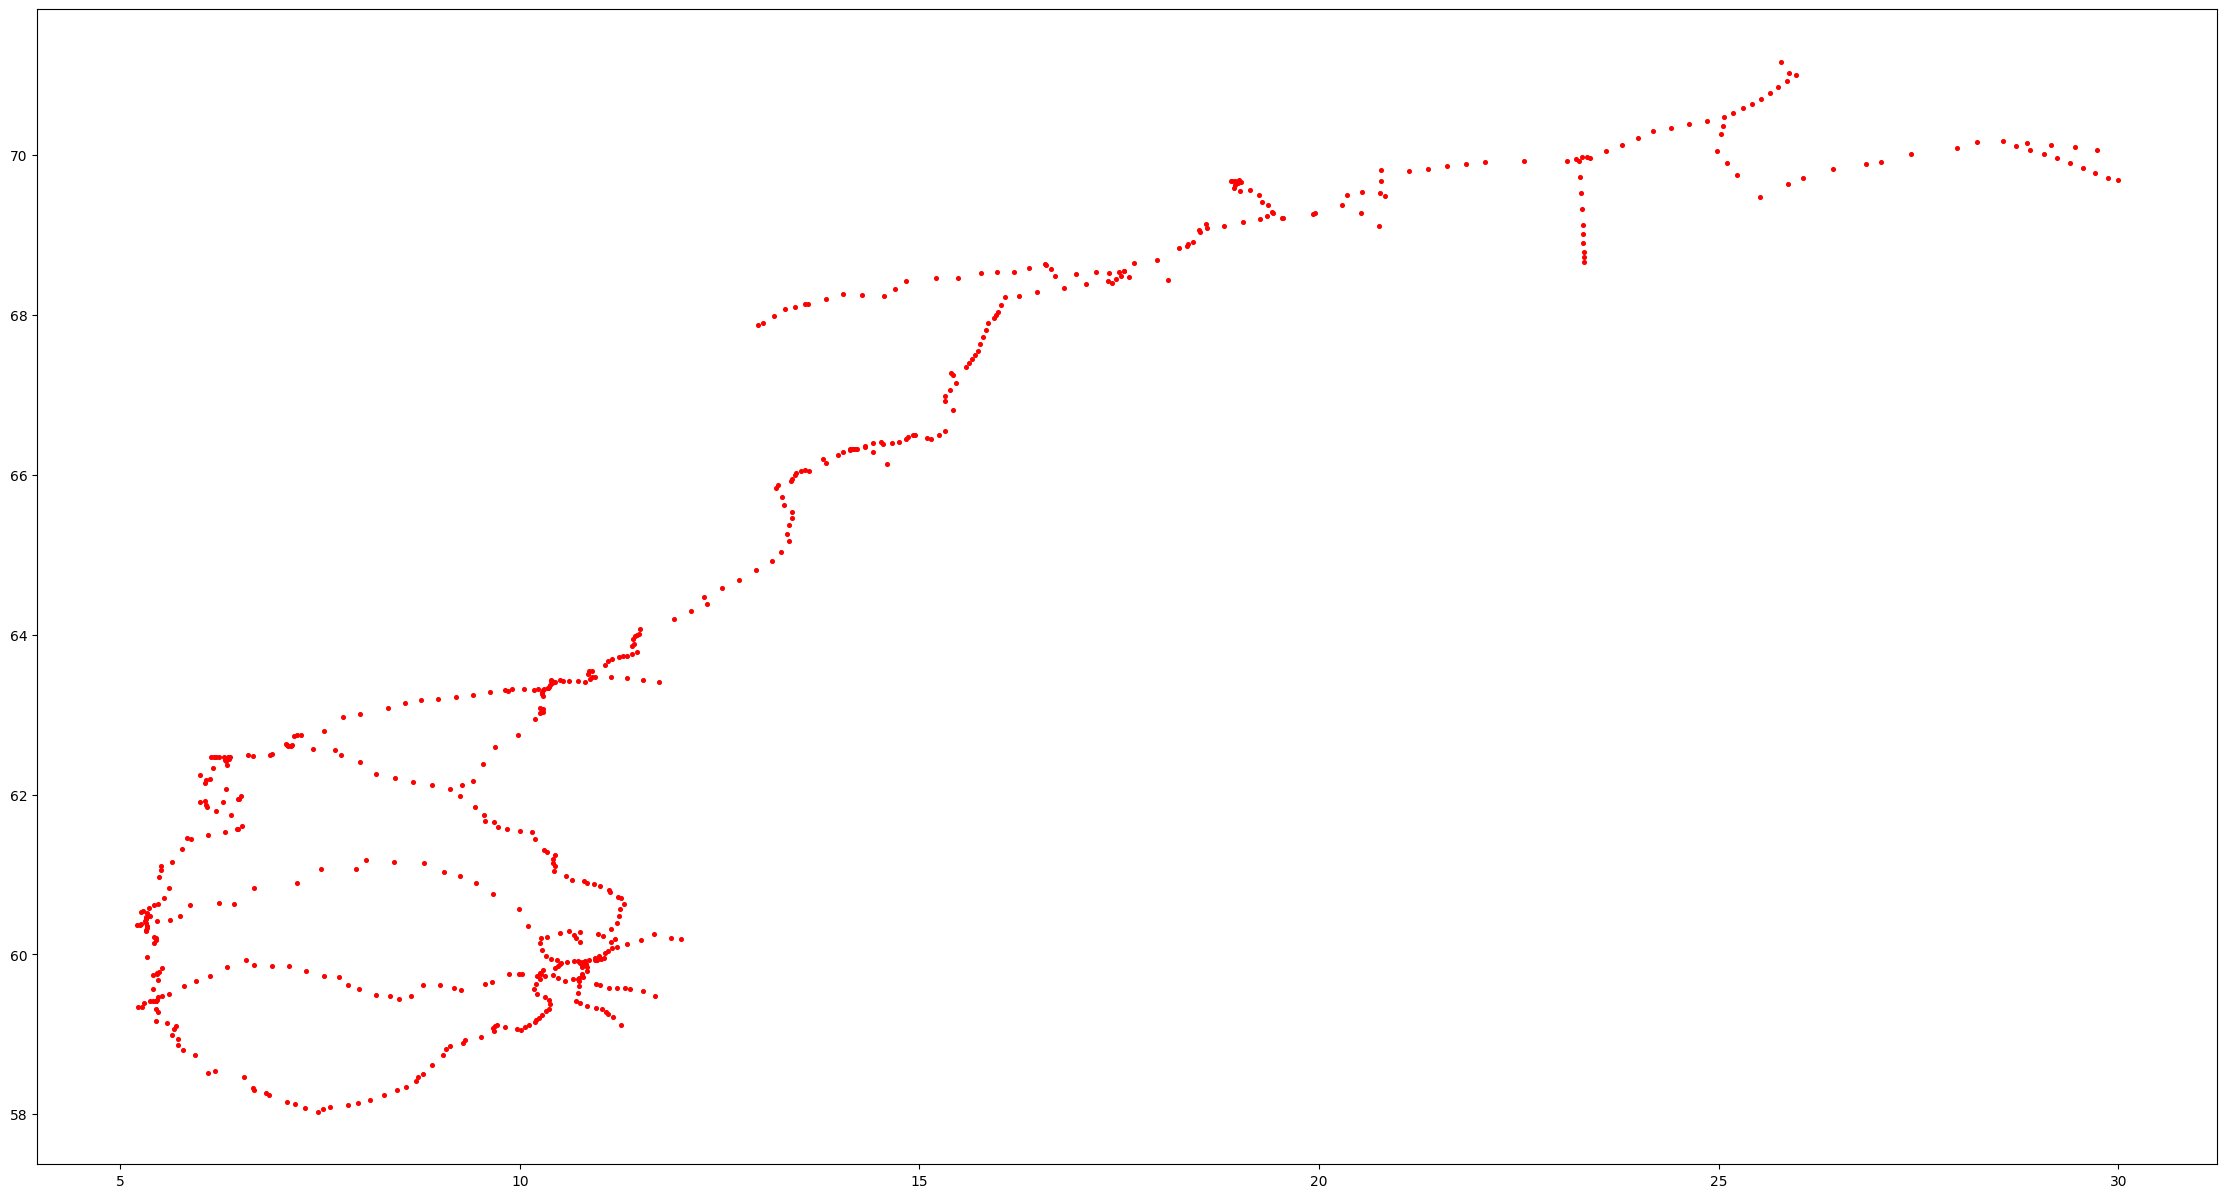

Much better.


In [22]:
# Set the size of the plot
fig, ax = plt.subplots(figsize=(30, 15))

# Plot the nodes and edges
new_gdf_ids.plot(ax=ax, color='red', markersize=7)
#new_edges_gdf.plot(ax=ax, color='blue')

# Show the plot
plt.show()
print("Much better.")


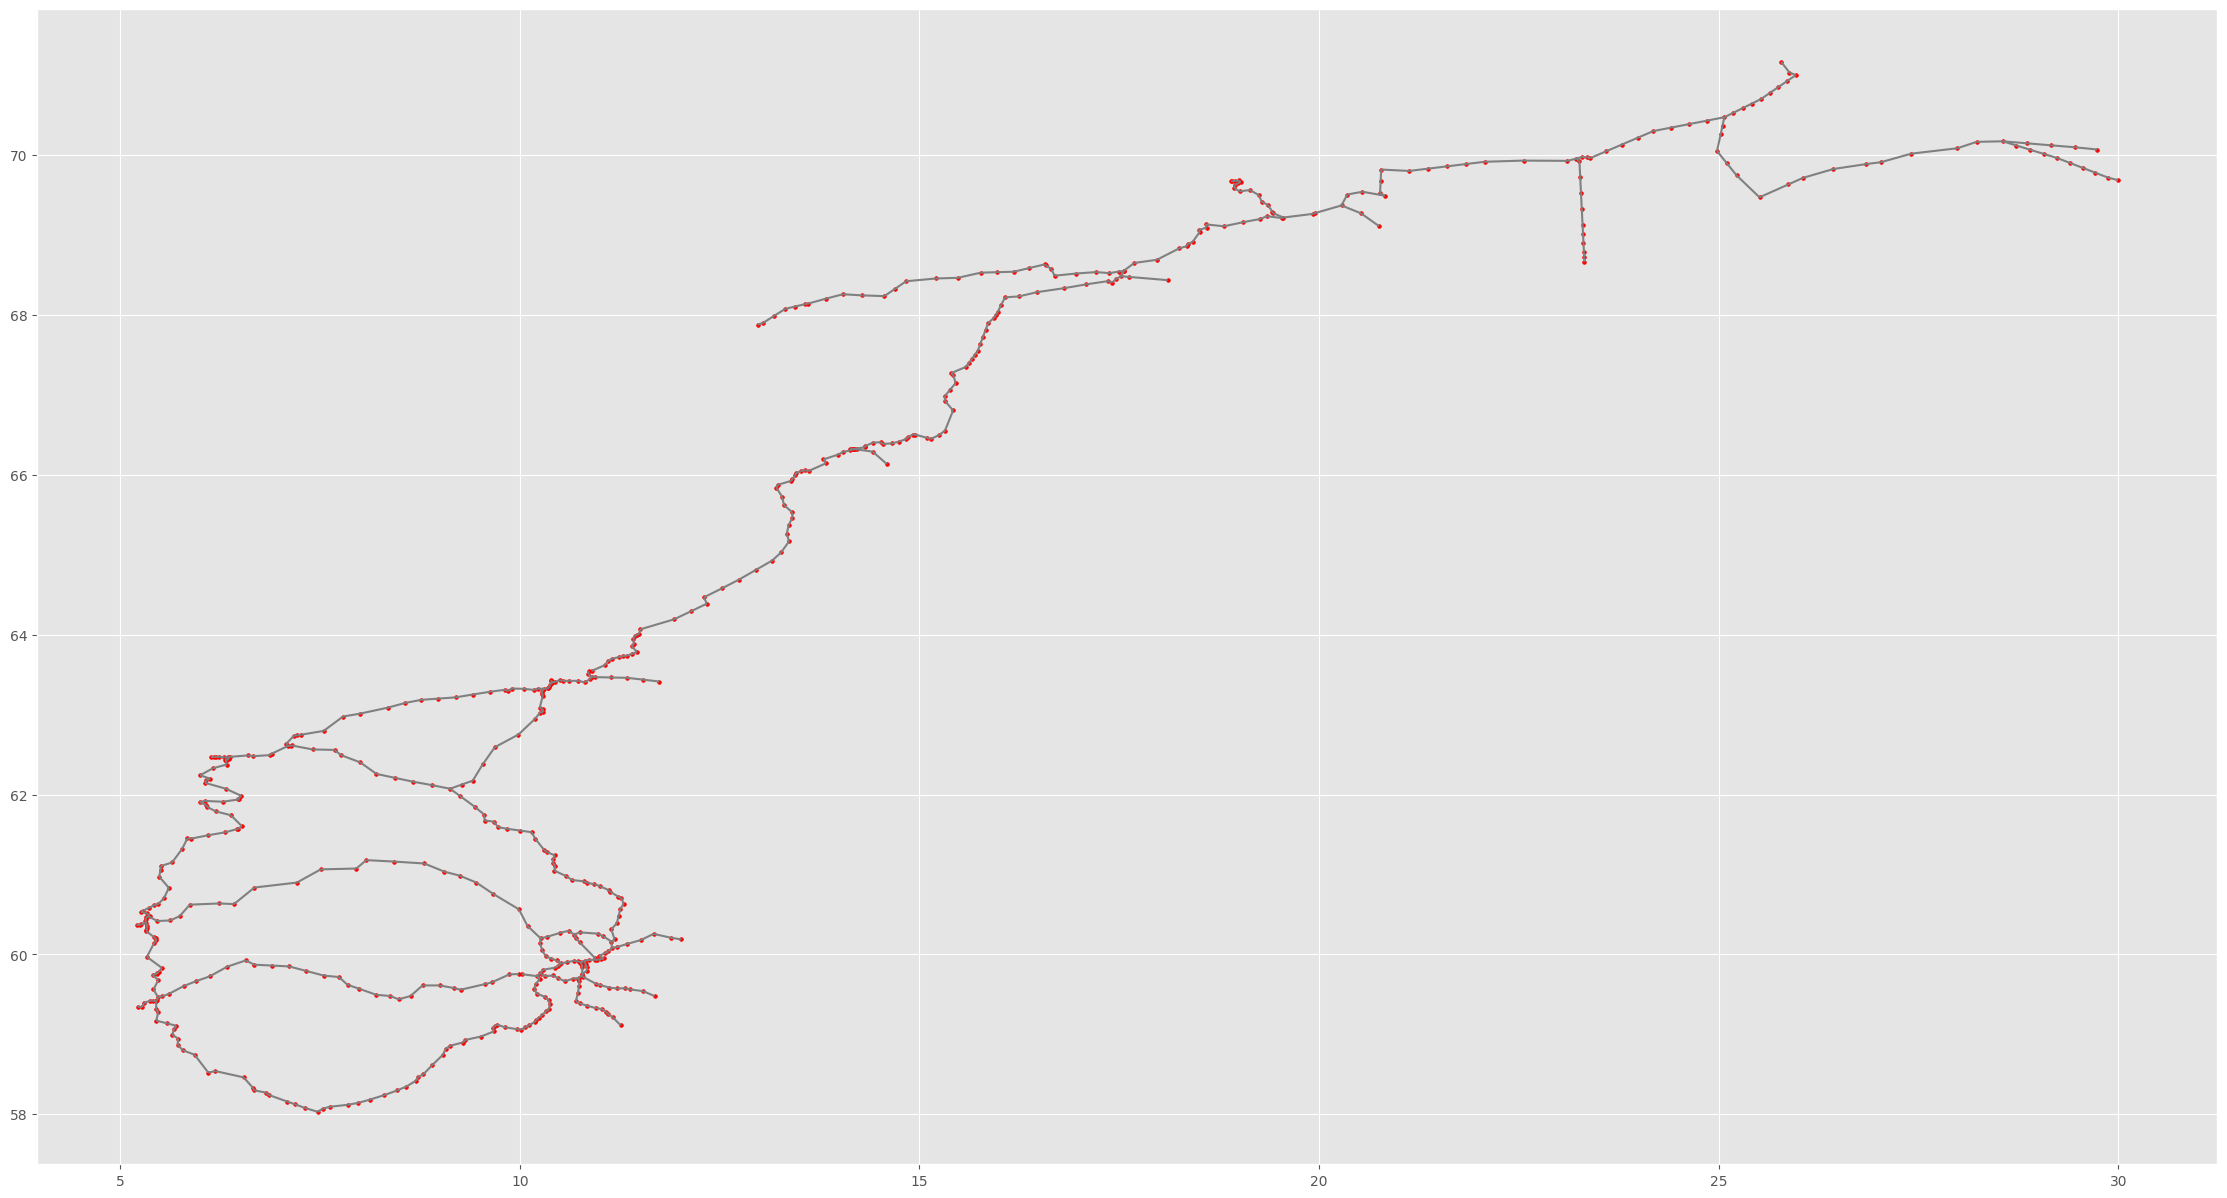

In [23]:
# Same plot but with the edges as well
# set style
plt.style.use('ggplot')
# Set the size of the plot
fig, ax = plt.subplots(figsize=(30, 15))

# Plot the nodes and edges
new_gdf_ids.plot(ax=ax, color='red', markersize=7)
new_edges_gdf.plot(ax=ax, color='grey')

# Show the plot
plt.show()


<h4>To better explore the networks nodes and edges we can use Foliums OpenStreetMap function to show an interactive map<h4>

In [24]:
# Create a folium map object centered on the first node in the node geodataframe
map_obj = folium.Map(location=[new_gdf_ids.geometry.iloc[0].y, new_gdf_ids.geometry.iloc[0].x], zoom_start=10)

# Create a feature group for the edges
edge_fg = folium.FeatureGroup(name="Edges")

# Add each edge as a line to the feature group, with a popup displaying the edge weight
for i, row in new_edges_gdf.iterrows():
    popup_str = f"Source: {row['source']}<br>Target: {row['target']}<br>Edge ID: {row['geometry']}"
    folium.PolyLine(locations=[(row.geometry.coords[0][1], row.geometry.coords[0][0]),
                                (row.geometry.coords[1][1], row.geometry.coords[1][0])],
                    popup=popup_str,
                    tooltip=f"Edge ({row['source']}, {row['target']})").add_to(edge_fg)

# Add the edge feature group to the map
edge_fg.add_to(map_obj)

# Create a feature group for the nodes
node_fg = folium.FeatureGroup(name="Nodes")

# Add each node as a marker to the feature group, with a popup displaying the node ID and label
for i, row in new_gdf_ids.iterrows():
    popup_str = f"ID: {row['osmid']}<br>Latitude: {row['latitude']}<br>Longitude: {row['longitude']}<br>Gradient: {row['gradient']}']"
    folium.Marker(location=[row.geometry.y, row.geometry.x],
                  popup=popup_str,
                  tooltip=f"Node {row['osmid']}").add_to(node_fg)

# Add the node feature group to the map
node_fg.add_to(map_obj)

# Add a layer control to the map, allowing the user to toggle the visibility of the edge and node feature groups
folium.LayerControl().add_to(map_obj)

# Display the map
map_obj

<h2>Now we have the nodes and edges, we need to calculate the lenght on the edges between the new node-neighbours<h2>

In [25]:
# Set Coordinate System

new_edges_gdf.crs = {'init': 'epsg:4326'}
# Convert the CRS to a projected CRS that uses meters or kilometers as the units
new_edges_gdf = new_edges_gdf.to_crs({'init': 'epsg:4326'}) # Change the EPSG code to the appropriate UTM zone for your data


C:\Users\anton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
# Using the Haversine formula to calculate length

from math import radians, sin, cos, sqrt, atan2

# define the radius of the Earth in meters
R = 6371000

# create an empty list to store the edge lengths
edge_lengths = []

# loop over the geometry column of the edges_gdf GeoDataFrame
for line in new_edges_gdf['geometry']:
    coords = line.coords
    
    src_lon, src_lat = radians(coords[0][0]), radians(coords[0][1])
    tgt_lon, tgt_lat = radians(coords[1][0]), radians(coords[1][1])
    
    d_lon = tgt_lon - src_lon
    d_lat = tgt_lat - src_lat
    
    a = sin(d_lat/2)**2 + cos(src_lat) * cos(tgt_lat) * sin(d_lon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    edge_lengths.append(distance)

# add the edge lengths to the edges_gdf GeoDataFrame
new_edges_gdf['length_m'] = edge_lengths

# Convert the length from meters to kilometers
new_edges_gdf['length_km'] = new_edges_gdf['length_m'] / 1000



In [78]:
# THIS IS THE GEOPANDAS .lenght functions - does not look correct. What kind of measurement is this?

# Create a new column called 'length' and set it to zero
#new_edges_gdf['length_2'] = 0

# Loop through each row in the geodataframe and calculate the length
#for index, row in new_edges_gdf.iterrows():
#    length = row['geometry'].length
#    new_edges_gdf.at[index, 'length_2'] = length

#new_edges_gdf.head()

In [27]:
# Get basic statistics for the two fields
#\033[1mlength, length_weight, grade, grade_abs, and geometry\033[0m")
print('\033[1mSimplified Edges:\033[0m')
print(new_edges_gdf[['length_m', 'length_km']].describe().round(2))

print('\n\033[1mInitial Edges::\033[0m')
print(edge_gdf[['length']].describe().round(2))


Simplified Edges:
       length_m  length_km
count    623.00     623.00
mean    8430.44       8.43
std     5721.96       5.72
min      448.18       0.45
25%     4012.40       4.01
50%     7587.06       7.59
75%    11560.01      11.56
max    32621.05      32.62

Initial Edges::
         length
count   8178.00
mean     995.46
std     2921.69
min        0.00
25%       32.96
50%      172.24
75%      480.45
max    30855.43


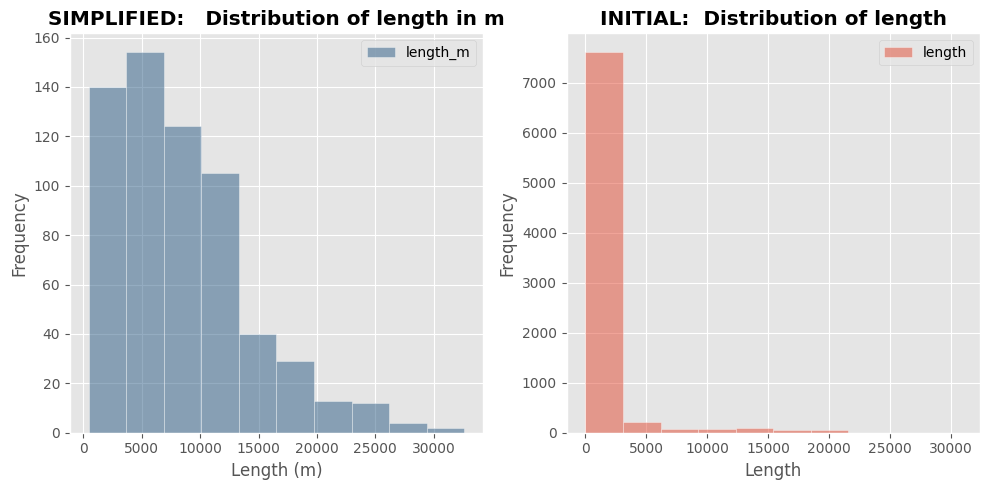

In [28]:
# set style
plt.style.use('ggplot')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram on the left subplot
axs[0].hist(new_edges_gdf['length_m'], bins=10, alpha=0.5, label='length_m', color='#2B5B84', edgecolor='white')
axs[0].set_title('SIMPLIFIED:   Distribution of length in m', fontweight='bold')
axs[0].set_xlabel('Length (m)')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# Plot the second histogram on the right subplot
axs[1].hist(edge_df['length'], alpha=0.5, label='length', edgecolor='white')
axs[1].set_title('INITIAL:  Distribution of length', fontweight='bold')
axs[1].set_xlabel('Length')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Show the figure
plt.tight_layout()
plt.show()

# set style to default
plt.style.use('default')

<h2>Now we need to add the effective length from the length and node-gradients<h2>

In [29]:
display(new_gdf_ids.head(1))
display(new_edges_gdf.head(1))

node   osmid   latitude  longitude  gradient isBridge isTunnel roadclass  \
0  155191  155191  60.786205  11.127466    143.16        0        0         0   

                    geometry  
0  POINT (11.12747 60.78620)

source  target                                           geometry  \
0  363114  155191  LINESTRING (11.11829 60.80021, 11.12747 60.78620)   

      length_m  length_km  
0  1635.452298   1.635452

In [30]:
def grade_per_meter(node_df, edge_df):
    const = 0.372
    grade_intervals = [-0.09, -0.07, -0.05, -0.03, -0.01, 0.01, 0.03, 0.05, 0.07, 0.09, 0.11]
    increased_consumption = [-0.332, -0.217, -0.148, -0.121, -0.073, 0.085, 0.152, 0.203, 0.306, 0.358, 0.552]

    edge_df['gradient_per_meter'] = 0

    iterator = len(edge_df)

    for i in range(0, iterator):    

        source = edge_df.at[i, 'source']
        target = edge_df.at[i, 'target']
        edge_length = edge_df.at[i, 'length_m']

        source_gradient = node_df.loc[node_df['osmid'] == source, 'gradient'].iloc[0]
        target_gradient = node_df.loc[node_df['osmid'] == target, 'gradient'].iloc[0]

        grade_diff = source_gradient - target_gradient

        edge_df.at[i, 'gradient_per_meter'] = grade_diff / edge_length


    return


In [31]:
grade_per_meter(new_gdf_ids, new_edges_gdf)
new_edges_gdf.head(3)

source  target                                           geometry  \
0  363114  155191  LINESTRING (11.11829 60.80021, 11.12747 60.78620)   
1  155191  351102  LINESTRING (11.12747 60.78620, 11.22847 60.72376)   
2  351102  229327  LINESTRING (11.22847 60.72376, 11.27194 60.70256)   

      length_m  length_km  gradient_per_meter  
0  1635.452298   1.635452           -0.006547  
1  8849.839694   8.849840           -0.007220  
2  3338.744306   3.338744            0.008365

In [237]:
new_edges_gdf['gradient_per_meter'].describe()

count    623.000000
mean      -0.000761
std        0.010967
min       -0.057723
25%       -0.003493
50%        0.000000
75%        0.004010
max        0.045717
Name: gradient_per_meter, dtype: float64

Normal Distribution.


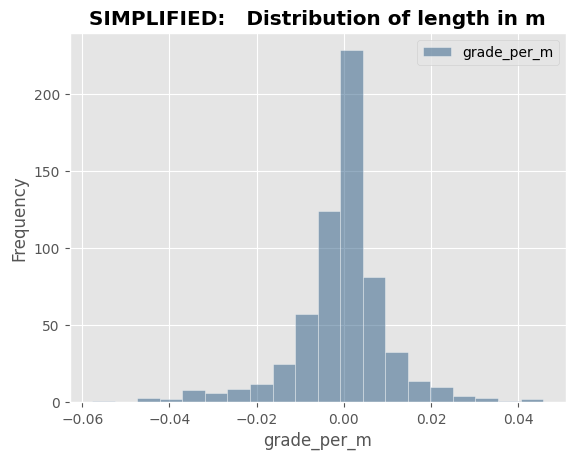

In [32]:
# set style
plt.style.use('ggplot')

# create histogram
plt.hist(new_edges_gdf['gradient_per_meter'], bins = 20, alpha=0.5, label='grade_per_m', edgecolor='white', color='#2B5B84')

# add titles and labels
plt.title('SIMPLIFIED:   Distribution of length in m', fontweight='bold')
plt.xlabel('grade_per_m')
plt.ylabel('Frequency')
plt.legend()

# display the plot
print('Normal Distribution.')
plt.show()

In [33]:
# move the 'geometry' column to the last position
new_edges_gdf = new_edges_gdf[['source', 'target', 'length_m', 'length_km', 'gradient_per_meter', 'geometry']]

# print the resulting GeoDataFrame
new_edges_gdf.head(1)

source  target     length_m  length_km  gradient_per_meter  \
0  363114  155191  1635.452298   1.635452           -0.006547   

                                            geometry  
0  LINESTRING (11.11829 60.80021, 11.12747 60.78620)

<h2>Converting Node and Edge GeoDataframes to one Network <h2>

In [34]:
# Set the CRS for both GeoDataFrames
new_gdf_ids.crs = {'init': 'epsg:4326'}
new_edges_gdf.crs = {'init': 'epsg:4326'}

# Rename the 'latitude' and 'longitude' columns in the node GeoDataFrame
new_gdf_ids = new_gdf_ids.rename(columns={'latitude': 'y', 'longitude': 'x'})
new_gdf_ids = new_gdf_ids.drop(columns='node')

# Add a 'key' column with a default value of 0
new_edges_gdf['key'] = 0

# Rename 'source' and 'target' columns to 'u' and 'v'
new_edges_gdf = new_edges_gdf.rename(columns={'source': 'u', 'target': 'v'})

# Rearanging order
new_edges_gdf = new_edges_gdf[['u', 'v', 'key', 'length_m', 'length_km', 'gradient_per_meter', 'geometry']]

C:\Users\anton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [35]:
display(new_gdf_ids.head(1))
display(new_edges_gdf.head(1))

osmid          y          x  gradient isBridge isTunnel roadclass  \
0  155191  60.786205  11.127466    143.16        0        0         0   

                    geometry  
0  POINT (11.12747 60.78620)

u       v  key     length_m  length_km  gradient_per_meter  \
0  363114  155191    0  1635.452298   1.635452           -0.006547   

                                            geometry  
0  LINESTRING (11.11829 60.80021, 11.12747 60.78620)

In [36]:
# Create an empty MultiDiGraph
N = nx.MultiDiGraph()

# Add nodes to the graph
for _, row in new_gdf_ids.iterrows():
    N.add_node(row['osmid'],
               y=row['y'],
               x=row['x'],
               gradient=row['gradient'],
               isBridge=row['isBridge'],
               isTunnel=row['isTunnel'],
               roadclass=row['roadclass'],
               geometry=row['geometry'])

# Add edges to the graph
for _, row in new_edges_gdf.iterrows():
    N.add_edge(row['u'],
               row['v'],
               key=row['key'],
               length_m=row['length_m'],
               length_km=row['length_km'],
               gradient_per_meter=row['gradient_per_meter'],
               geometry=row['geometry'])




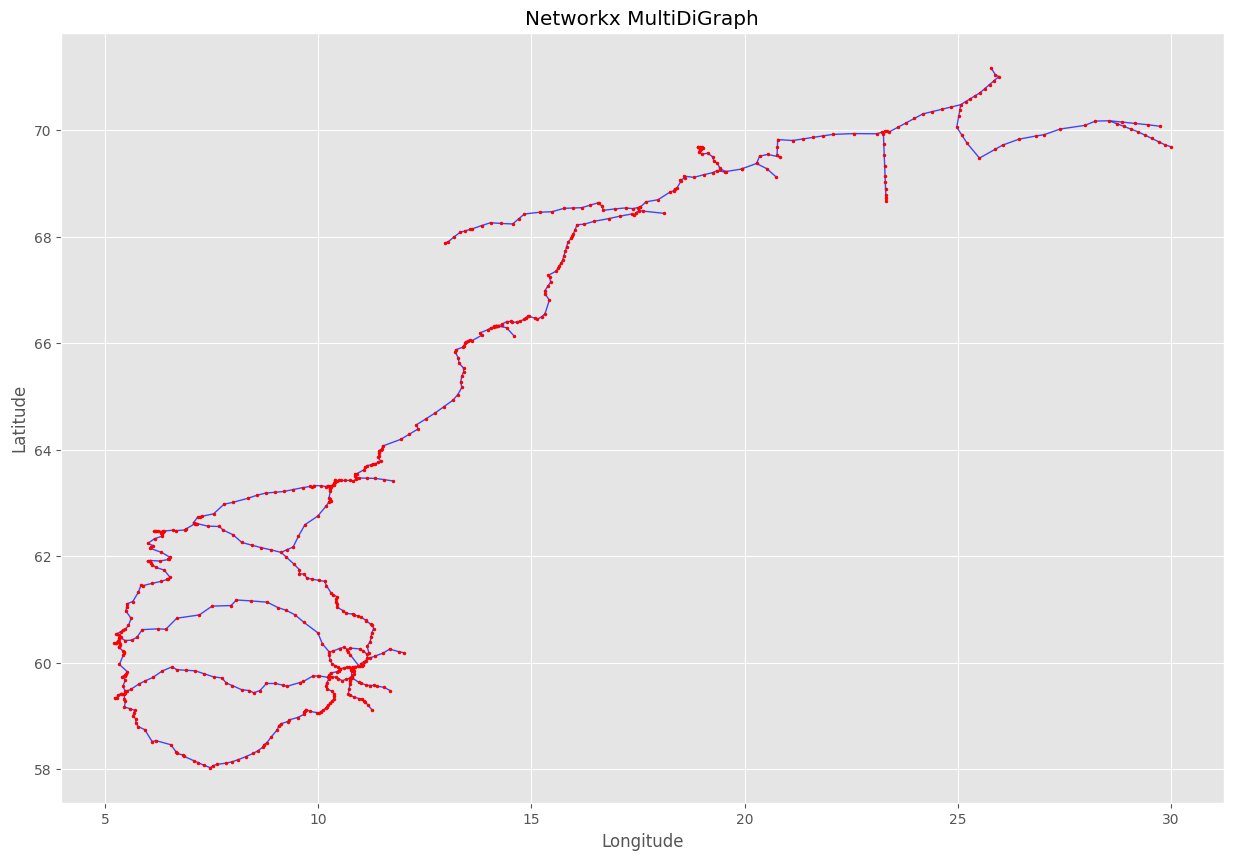

In [37]:
# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the edges
for u, v, data in N.edges(data=True):
    # Get the edge geometry
    edge_geometry = data['geometry']
    
    # Extract the x and y coordinates of the edge as separate lists
    x_coords, y_coords = edge_geometry.xy
    
    # Plot the edge
    ax.plot(x_coords, y_coords, color='blue', alpha=0.7, linewidth=1)

# Plot the nodes
for node, data in N.nodes(data=True):
    # Get the node geometry
    node_geometry = data['geometry']
    
    # Extract the x and y coordinates of the node
    x, y = node_geometry.xy
    
    # Plot the node
    ax.plot(x, y, 'o', color='red', markersize=1.5)

# Set the axis properties
ax.set_title('Networkx MultiDiGraph')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


<h3>... or like this<h3>

In [38]:
# Update the x and y columns to match the geometry column coordinates
new_gdf_ids['x'] = new_gdf_ids['geometry'].x
new_gdf_ids['y'] = new_gdf_ids['geometry'].y

# Set the index of the edge GeoDataFrame to a MultiIndex with columns (u, v, key)
new_edges_gdf.set_index(['u', 'v', 'key'], inplace=True)

# Create the MultiDiGraph from the GeoDataFrames
N2 = ox.graph_from_gdfs(new_gdf_ids, new_edges_gdf, graph_attrs={'crs': 'epsg:4326'})


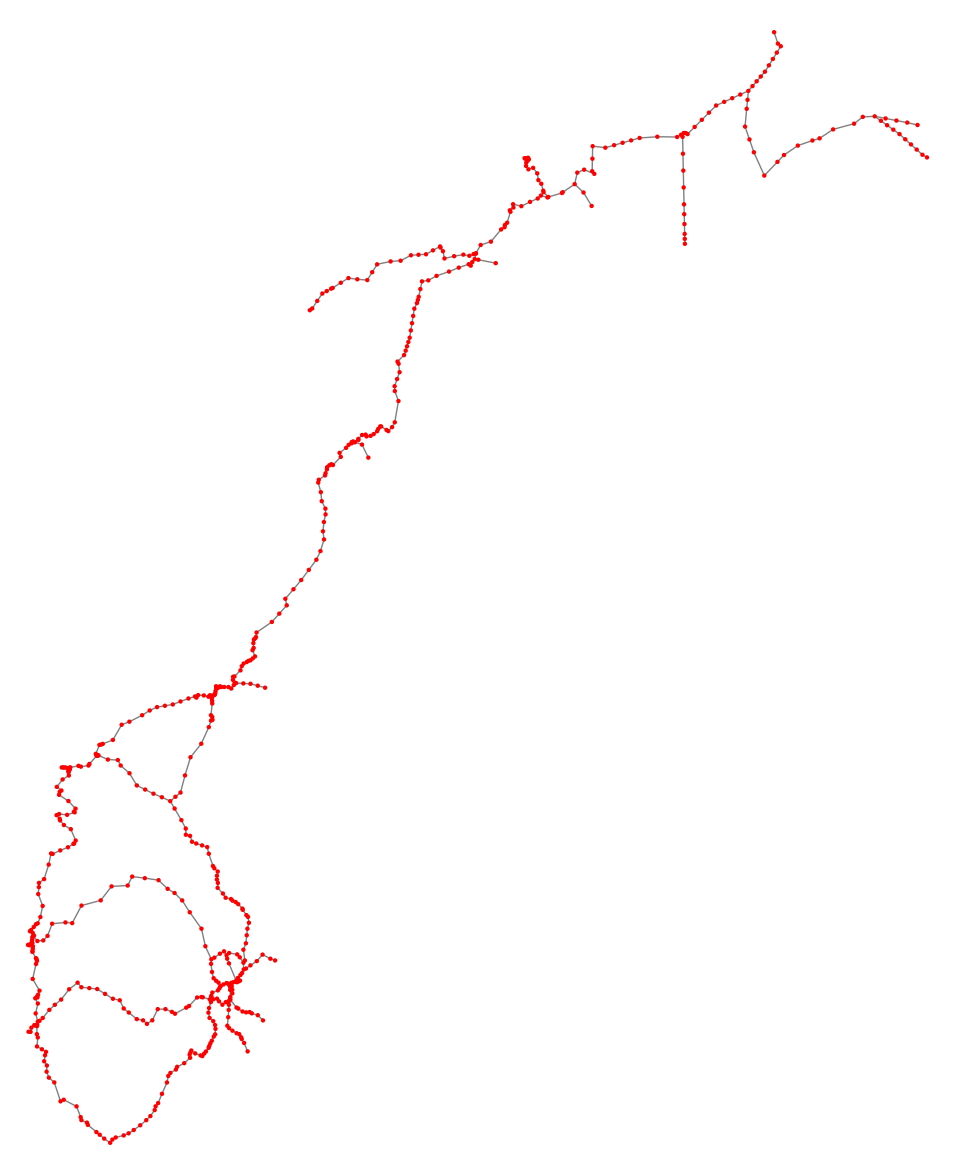

(<Figure size 3000x1500 with 1 Axes>, <AxesSubplot:>)

In [39]:
# Plot the graph
ox.plot_graph(N2, figsize=(30, 15), node_color="red", edge_color="gray", bgcolor="white", node_size=10, edge_linewidth=1)

<h2>Adding traffick counts to edges<h2>

In [42]:
# Import Traffic Counts:
# Load volume dataset
csv_pd=pd.read_excel(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\New_Traffic\weekly_data\weekly_data_xl.xlsx")
# csv_pd.drop(columns='Unnamed: 0', inplace=True)
csv_pd.head(3)

id            name        lat        lon  volume  year  month  \
0  41379V1201935  MESNADALSARMEN  61.115044  10.456279   13023  2018      1   
1  41379V1201935  MESNADALSARMEN  61.115044  10.456279   13998  2018      2   
2  41379V1201935  MESNADALSARMEN  61.115044  10.456279   13878  2018      3   

   volume1  volume2  
0     6512     6512  
1     6999     6999  
2     6939     6939

In [43]:
csv_pd_woDup = csv_pd.copy().drop_duplicates('id').reset_index(drop=True)
csv_pd_woDup.head(3)

id            name        lat        lon  volume  year  month  \
0  41379V1201935  MESNADALSARMEN  61.115044  10.456279   13023  2018      1   
1   43294V181263  MEHEIA STASJON  59.629705   9.499576    4098  2018      1   
2   76082V578594        Svemarka  63.542709  10.862757    6651  2018      1   

   volume1  volume2  
0     6512     6512  
1     2049     2049  
2     3326     3326

In [44]:
# Remove volume1 and volume2
csv_pd_woDup=csv_pd_woDup.drop("volume1", axis="columns")
csv_pd_woDup=csv_pd_woDup.drop("volume2", axis="columns")
csv_pd_woDup['geometry'] = csv_pd_woDup.apply(lambda x: Point(x['lon'], x['lat']), axis=1)
csv_pd_woDup.head(3)

id            name        lat        lon  volume  year  month  \
0  41379V1201935  MESNADALSARMEN  61.115044  10.456279   13023  2018      1   
1   43294V181263  MEHEIA STASJON  59.629705   9.499576    4098  2018      1   
2   76082V578594        Svemarka  63.542709  10.862757    6651  2018      1   

                      geometry  
0  POINT (10.456279 61.115044)  
1   POINT (9.499576 59.629705)  
2  POINT (10.862757 63.542709)

In [45]:
csv_pd_woDup.describe()

lat         lon        volume    year       month
count  641.000000  641.000000    641.000000   641.0  641.000000
mean    62.116319   10.880545  10708.436817  2018.0    1.382215
std      3.591697    5.427137  14834.163826     0.0    1.792065
min     58.031728    5.277124      0.000000  2018.0    1.000000
25%     59.775641    6.715169   1745.000000  2018.0    1.000000
50%     60.414129   10.421482   5186.000000  2018.0    1.000000
75%     63.320310   11.241171  12731.000000  2018.0    1.000000
max     71.091307   31.103498  81453.000000  2018.0   12.000000

In [46]:
traffic_counts = gpd.GeoDataFrame(csv_pd_woDup, geometry="geometry")
points_df = traffic_counts.copy()
traffic_counts.head(3)

id            name        lat        lon  volume  year  month  \
0  41379V1201935  MESNADALSARMEN  61.115044  10.456279   13023  2018      1   
1   43294V181263  MEHEIA STASJON  59.629705   9.499576    4098  2018      1   
2   76082V578594        Svemarka  63.542709  10.862757    6651  2018      1   

                    geometry  
0  POINT (10.45628 61.11504)  
1   POINT (9.49958 59.62971)  
2  POINT (10.86276 63.54271)

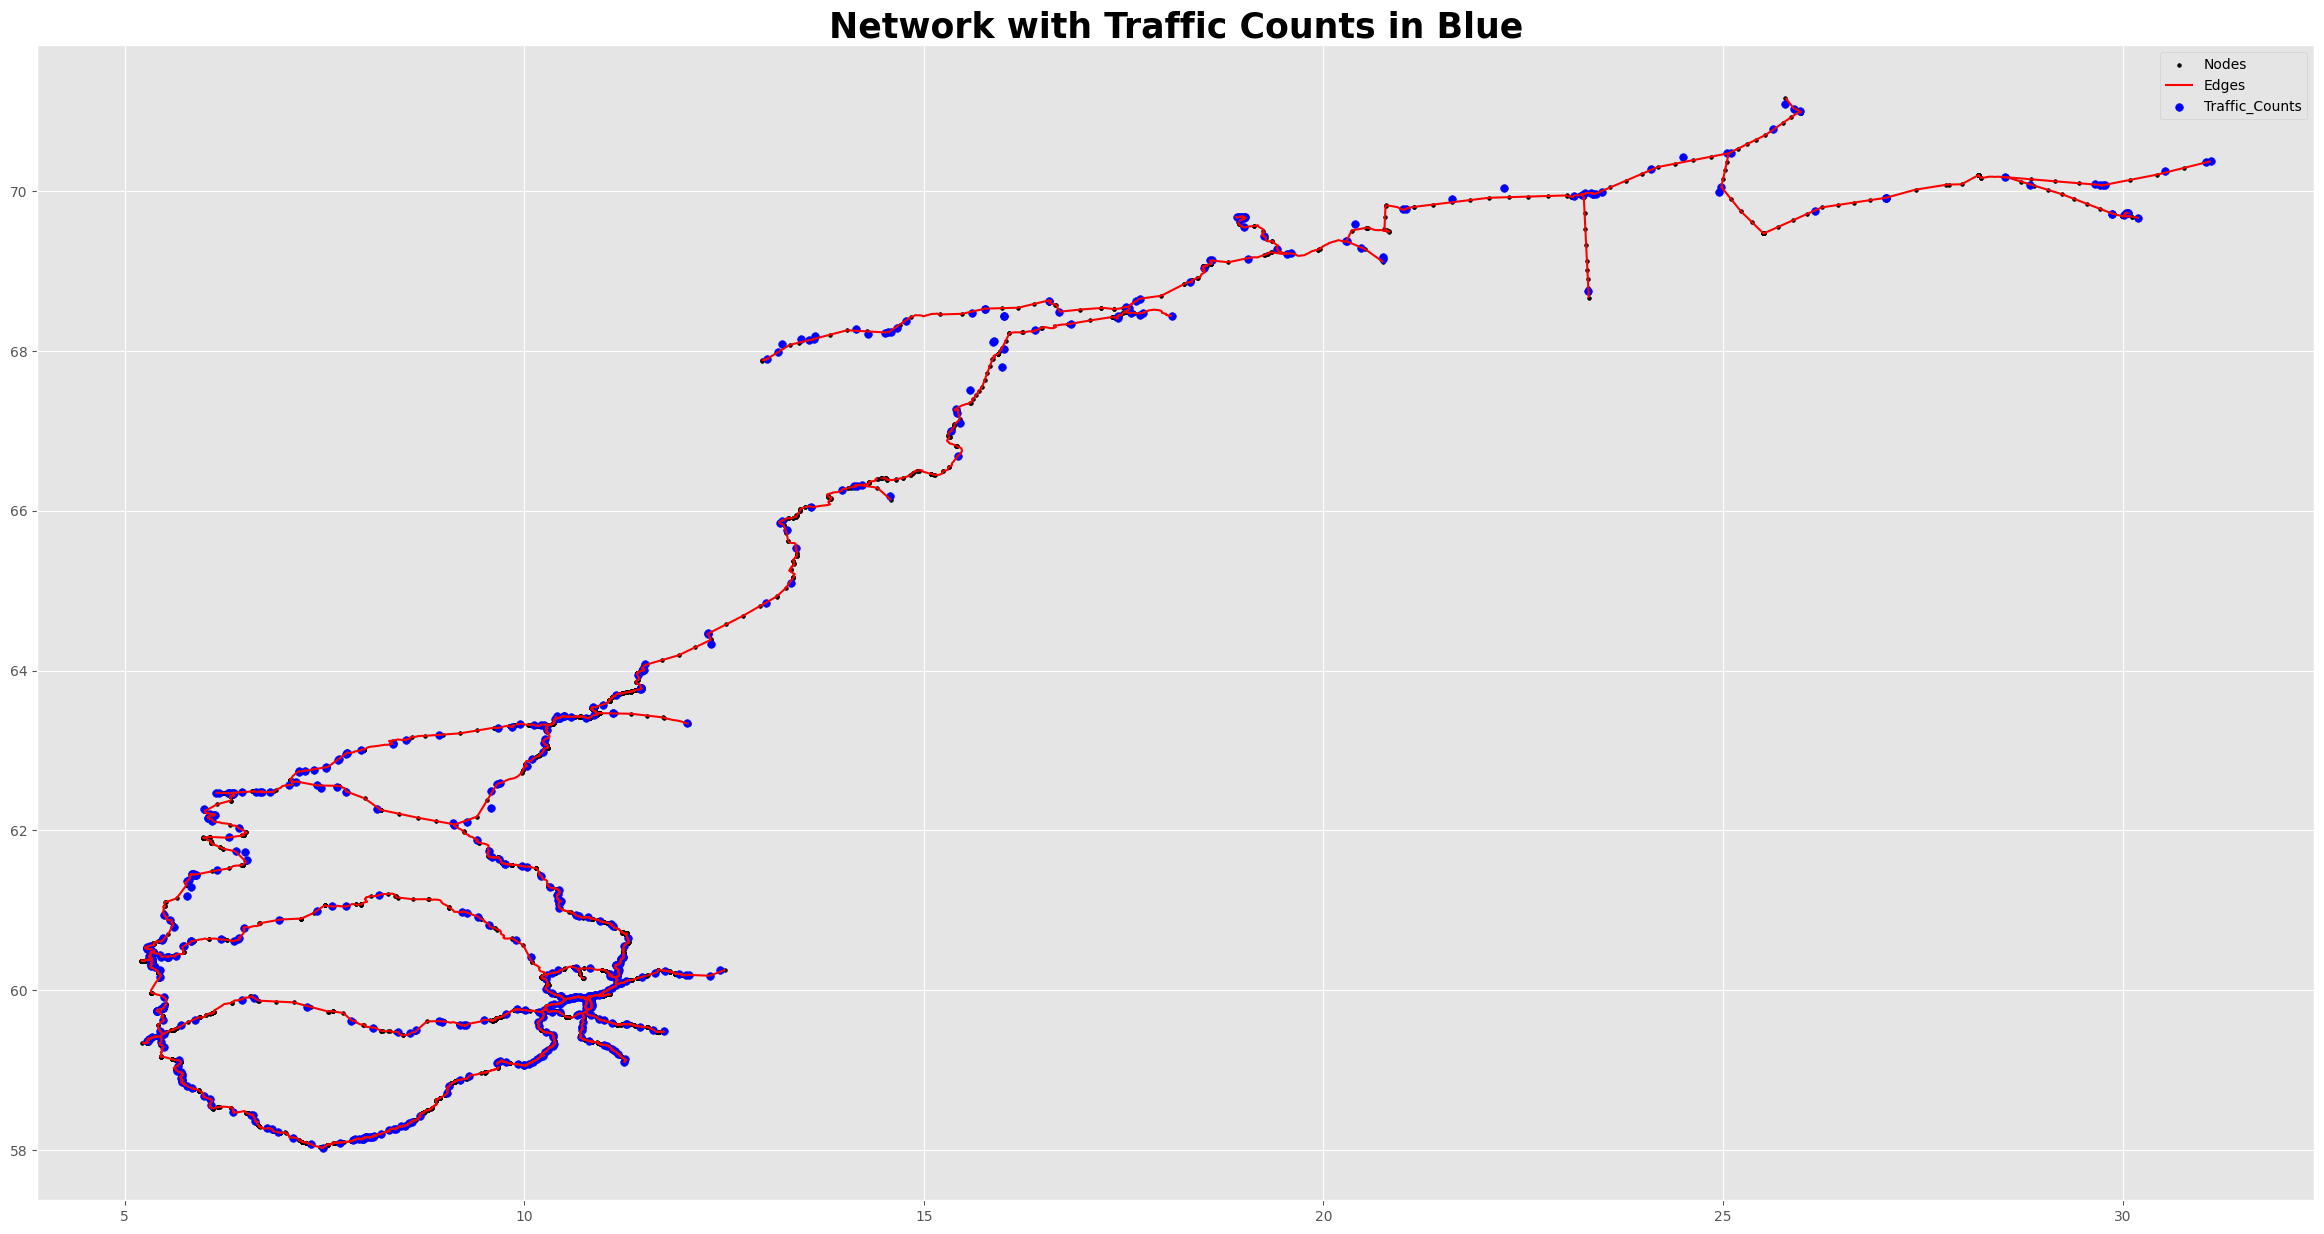

In [47]:
# set style to default
plt.style.use('ggplot')

# set up the plot
fig, ax = plt.subplots(figsize=(30, 15))

node_gdf.plot(ax=ax, color='black', markersize=7)
edge_gdf.plot(ax=ax, color='red')
traffic_counts.plot(ax=ax, color='blue', markersize=30)
ax.legend(['Nodes', 'Edges', 'Traffic_Counts'])
ax.set_title('Network with Traffic Counts in Blue', fontweight='bold', fontsize=25)

# display the plot
plt.show()


<h4>From the plot above we clearly notice (at least) two things:<h4>
<h5>First - from a visual perspective, the traffic counts represent a big (if not all) amount of the "important" roads (edges). In other words, there are always traffic counts on dead-ends, and around the crossroads.<h5>
<h5>Second, and maybe the most challenging - we notice there are not traffic counts BETWEEN all nodes, and therfore, not counts on all edges. How we will calculate this is for the time being uncertain. <h5>

<h3>Adding counts to edges:<h3>

For some reason an error occurs when using network N2 - something wrong?

In [107]:
# loop through each point in the dataframe and find the nearest edge on the road network graph
for idx, row in tqdm(points_df.iterrows(), total=points_df.shape[0]):

    # get the shapely Point object for the current traffic point
    point = row['geometry']
    # find the nearest point on the road network graph
    nearest_node = None
    min_distance = float('inf')

    for node in N.nodes:
        # extract (x, y) coordinates from node attributes
        x, y = N.nodes[node]['x'], N.nodes[node]['y']
        node_point = Point(x, y)
        distance = point.distance(node_point)
        if distance < min_distance:
            nearest_node = node
            min_distance = distance
        else:
            pass # May need an additional else-statement which takes account for distance > min_distance

    # find the closest edge to the nearest point on the road network graph
    nearest_edge = None
    min_distance = float('inf')

    for edge in N.edges:
        # get the coordinates of the nodes in the edge tuple
        node1 = N.nodes[edge[0]]
        node2 = N.nodes[edge[1]]
        coords = [(node1['x'], node1['y']), (node2['x'], node2['y'])]

        # construct a LineString from the coordinates and compute the distance to the point
        distance = point.distance(LineString(coords))

        if distance < min_distance:
            nearest_edge = edge
            min_distance = distance
        else:
            pass
    
    # if the distance between the point and the closest point on the edge is below a certain threshold,
    # add the volume data to that edge's attribute in the road network graph
    if min_distance < 50: # adjust the threshold as needed
    # create a dictionary to hold the edge attributes
        edge_attrs = {}

        # update the dictionary with the new 'volume' attribute
        edge_attrs['trafficPoint_ID'] = row['id']
        edge_attrs['volume'] = row['volume']


        # update the edge attributes in the graph using the dictionary
        N.edges[nearest_edge].update(edge_attrs)



100%|██████████| 641/641 [00:12<00:00, 50.79it/s]


In [115]:
import osmnx as ox

# Add the crs attribute to your graph
N.graph["crs"] = "EPSG:4326"
# Convert the graph to a GeoDataFrame
gdf_edges = ox.graph_to_gdfs(N, nodes=False)

# loop through each point in the dataframe and find the nearest edge on the road network graph
for idx, row in tqdm(points_df.iterrows(), total=points_df.shape[0]):

    # get the shapely Point object for the current traffic point
    point = row['geometry']

    # Find the nearest edges to the point using osmnx
    nearest_edges, distances = ox.distance.nearest_edges(N, X=[point.x], Y=[point.y], return_dist=True)
    nearest_edge, min_distance = nearest_edges[0], distances[0]

    # if the distance between the point and the closest point on the edge is below a certain threshold,
    # add the volume data to that edge's attribute in the road network graph
    if min_distance < 5:  # adjust the threshold as needed
        # create a dictionary to hold the edge attributes
        edge_attrs = {}

        # update the dictionary with the new 'volume' attribute
        edge_attrs['trafficPoint_ID'] = row['id']
        edge_attrs['volume'] = row['volume']

        # update the edge attributes in the graph using the dictionary
        N.edges[nearest_edge].update(edge_attrs)



100%|██████████| 641/641 [00:04<00:00, 139.47it/s]


In [117]:
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString
from tqdm import tqdm

# Add a 'volume' attribute to each edge with an initial value of 0
for u, v, k, data in N.edges(data=True, keys=True):
    data['volume'] = 0
    data['trafficPoint_ID'] = None

# loop through each point in the dataframe and find the nearest edge on the road network graph
for idx, row in tqdm(points_df.iterrows(), total=points_df.shape[0]):
    point = row['geometry']
    nearest_edge = None
    min_distance = float('inf')

    # Find the nearest edges to the point using osmnx
    nearest_edges, distances = ox.distance.nearest_edges(N, X=[point.x], Y=[point.y], return_dist=True)

    for edge, distance in zip(nearest_edges, distances):
        if distance < min_distance:
            nearest_edge = edge
            min_distance = distance

    # Update the edge attributes in the graph
    u, v, k = nearest_edge
    edge_attrs = N[u][v][k]
    edge_attrs['trafficPoint_ID'] = row['id']
    edge_attrs['volume'] = row['volume']


100%|██████████| 641/641 [00:04<00:00, 138.73it/s]


In [118]:
volume_testing2=nx.to_pandas_edgelist(N)
volume_testing2.to_csv("simplified_volume2.csv", index=False)
simp_map2=pd.read_csv(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\new_simplified\simplified_volume2.csv")

simp_map2["volume"].nunique()

358

In [51]:
volume_testing=nx.to_pandas_edgelist(N)

volume_testing.to_csv("simplified_volume.csv", index=False)

#Testing the volume mapped

In [83]:
simp_map=pd.read_csv(r"C:\Users\anton\Desktop\Master-Oppgave\Kode\new_simplified\simplified_volume.csv")



In [84]:
print(simp_map["volume"].nunique())

358


In [86]:

simp_map.head()


source   target     length_m  length_km  \
0  203067   203338  4227.062994   4.227063   
1  225533  1804949  8602.295409   8.602295   
2  229327  1287001  7869.839437   7.869839   
3  232649   232847  4687.452482   4.687452   
4  232847   232965  4963.772675   4.963773   

                                            geometry trafficPoint_ID  \
0  LINESTRING (11.101135541845837 63.668650098783...   37345V1742835   
1  LINESTRING (10.279030527523267 60.050952962361...    72438V180781   
2  LINESTRING (11.271937586492612 60.702559900949...   91169V1801368   
3  LINESTRING (10.441589615197381 61.104369234385...   87656V1060615   
4  LINESTRING (10.415216340628987 61.144554610651...   84996V1060616   

   gradient_per_meter  volume  
0            0.008721    6437  
1           -0.024180   11578  
2           -0.001898   12149  
3           -0.005502   14864  
4           -0.001783    8919

In [90]:
simp_map.dtypes

source                  int64
target                  int64
length_m              float64
length_km             float64
geometry               object
trafficPoint_ID        object
gradient_per_meter    float64
volume                  int64
dtype: object